# Analysis of short 20 sec Power Spectra

In [1]:

import plotly
import plotly.graph_objs as go

# Importing Python and external packages


import os
import sys
import importlib
from importlib import reload 
from dataclasses import dataclass, field, fields
from itertools import compress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

import scipy
from scipy import stats
from scipy import signal
from scipy.signal import spectrogram, hann, butter, filtfilt, freqz

import seaborn as sns
import pingouin as pg
from itertools import combinations
from statannotations.Annotator import Annotator

import openpyxl
from openpyxl import Workbook, load_workbook
# import xlrd
import pickle
import json
import csv
import h5py
import fooof
from fooof.plts.spectra import plot_spectrum

#mne
from pathlib import Path
import mne_bids
from mne_bids import (
    BIDSPath,
    inspect_dataset,
    mark_channels)
import mne
from mne.time_frequency import tfr_morlet 

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
jennifer_user_path = os.getcwd()
while jennifer_user_path[-14:] != 'jenniferbehnke':
    jennifer_user_path = os.path.dirname(jennifer_user_path)

# directory to this Repository
project_path = os.path.join(jennifer_user_path, 'code', 'Monopolar_power_estimation', 'monopolar_directional_beta')
sys.path.append(project_path)

os.chdir(project_path)

import src.monopolar_bssu.utils.find_folders as find_folders
importlib.reload(find_folders)

# import PyPerceive

project_path = find_folders.chdir_repository("Py_Perceive")

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)

import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as PyPerceive_find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

# import meet

project_path = find_folders.chdir_repository("meet")

import meet as meet

# import all functions from BetaSenSightLongterm
project_path = find_folders.chdir_repository("monopolar_directional_beta")


# externalized LFP
import src.monopolar_bssu.externalized_lfp.externalized_lfp as externalized
import src.monopolar_bssu.externalized_lfp.feats_ssd as feats_ssd

# monopolar Referencing
import src.monopolar_bssu.monopol_bssu_methods.MonoRef_JLB as MonoRefJLB
#import src.bssu.monopolar.GroupMonopolarPSD as groupMonopol
import src.monopolar_bssu.monopol_bssu_methods.monoRef_weightPsdAverageByCoordinateDistance as MonoRefWeightedCoordinateDistance
import src.monopolar_bssu.monopol_bssu_methods.bssu_contacts_maximal_beta as bssu_contacts
import src.monopolar_bssu.monopol_bssu_methods.monoRef_Strelow as detec_strelow

# Power Spectra
import src.monopolar_bssu.power_spectra.power_spectra_externalized as power_spectra_externalized

# Clinical stimulation parameters
import src.monopolar_bssu.clinical_contacts.activeStimulationContacts as activeStimContacts

# comparison analysis
import src.monopolar_bssu.comparison_analysis.monopol_comparison_tests as monopol_comparison_tests
import src.monopolar_bssu.comparison_analysis.monopol_method_comparison as monopol_method_comparison

# utility functions
import src.monopolar_bssu.utils.loadResults as loadResults
import src.monopolar_bssu.utils.find_folders as find_folders
import src.monopolar_bssu.utils.io_externalized as io_externalized
import src.monopolar_bssu.utils.io_percept as io_percept
import src.monopolar_bssu.utils.io_monopolar_comparison as io_monopolar_comparison
import src.monopolar_bssu.utils.externalized_lfp_preprocessing as externalized_lfp_preprocessing
import src.monopolar_bssu.utils.percept_lfp_preprocessing as percept_lfp_preprocessing
import src.monopolar_bssu.utils.tmsi_poly5reader as tmsi_poly5reader

# short time stability 
import src.monopolar_bssu.short_time_stability_power.externalized_short_chunks as externalized_short_chunks


importlib.reload(externalized)
importlib.reload(feats_ssd)
importlib.reload(loadResults)
importlib.reload(MonoRefJLB)
importlib.reload(MonoRefWeightedCoordinateDistance)
importlib.reload(bssu_contacts)
importlib.reload(detec_strelow)
importlib.reload(power_spectra_externalized)
importlib.reload(activeStimContacts)
importlib.reload(monopol_comparison_tests)
importlib.reload(monopol_method_comparison)
importlib.reload(loadResults)
importlib.reload(find_folders)
importlib.reload(io_externalized)
importlib.reload(io_percept)
importlib.reload(io_monopolar_comparison)
importlib.reload(externalized_lfp_preprocessing)
importlib.reload(percept_lfp_preprocessing)
importlib.reload(tmsi_poly5reader)
importlib.reload(externalized_short_chunks)


# load if you want to see complete Dataframes
pd.set_option("display.max_rows", None)

Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data
Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data
Excel file loaded:  patient_metadata.xlsx 
loaded from:  /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/data


In [11]:
bssu_data_loaded = io_externalized.load_externalized_pickle(filename="externalized_directional_bssu_channels", reference="bipolar_to_lowermost")

In [4]:
bssu_data_loaded.loc[bssu_data_loaded.BIDS_id == "noBIDS24"].head()

,BIDS_id,subject,hemisphere,session,subject_hemisphere,bipolar_channel,time_stamps_250Hz,lfp_resampled_250Hz,filtered_lfp_250Hz,only_high_pass_lfp_250Hz,n_samples_250Hz
0,noBIDS24,024,Right,pre-IPG,024_Right,01,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[-0.05402010422003183, -0.05403081637623904, -...","[5.2580631866917335e-08, -8.07395841279414e-06...","[2.5097978689854487e-06, -7.857326029623908e-0...",30000
0,noBIDS24,024,Right,pre-IPG,024_Right,02,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[-0.056680708938918, -0.05668959381403876, -0....","[4.051196847962224e-07, -5.867921586363009e-06...","[1.5092891581170489e-06, -7.141439125523177e-0...",30000
0,noBIDS24,024,Right,pre-IPG,024_Right,03,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[-0.010260039408472432, -0.010269640405165523,...","[3.3754137369927164e-07, -7.440385359100413e-0...","[2.0044483669667603e-06, -7.321759874859456e-0...",30000
0,noBIDS24,024,Right,pre-IPG,024_Right,12,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[-0.00266060471888617, -0.002658777437799721, ...","[3.525390530730823e-07, 2.2060368266151104e-06...","[-1.0006768531720542e-06, 7.157169106543659e-0...",30000
0,noBIDS24,024,Right,pre-IPG,024_Right,13,"[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...","[0.043760064811559404, 0.04376117597107352, 0....","[2.849607418726738e-07, 6.335730536778569e-07,...","[-5.054836602006715e-07, 5.354331240126414e-07...",30000


## Load the externalized Power Spectra 2 min and 20 sec chunks: 2 filter options
- notch_and_band_pass_filtered: to analyze beta power without FOOOF
- only_high_pass_filtered: to run FOOOF on 20sec chunks and then analyze periodic beta power

1. To write 20 sec power spectra chunks: use externalized_lfp.ipynb and power_spectra_externalized.py 

2. Write group dataframe 

In [14]:
group_chunk_df = power_spectra_externalized.group_20sec_power_spectra_externalized_bssu(incl_bids_id=["all"], filtered="notch_and_band_pass_filtered")


No data for L002
power_spectra_BSSU_externalized_20sec_group_notch_and_band_pass_filtered.pickle 
written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results


In [13]:
load_group_df = io_externalized.load_externalized_pickle(filename="power_spectra_BSSU_externalized_20sec_group_notch_and_band_pass_filtered")
load_group_df.head()

,bids_id,hemisphere,channel,chunks,fourier_transform_2min,filtered,subject
0,noBIDS24,Right,01,"{1: [5.2580631866917335e-08, -8.07395841279414...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024
1,noBIDS24,Right,02,"{1: [4.051196847962224e-07, -5.867921586363009...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024
2,noBIDS24,Right,03,"{1: [3.3754137369927164e-07, -7.44038535910041...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024
3,noBIDS24,Right,12,"{1: [3.525390530730823e-07, 2.2060368266151104...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024
4,noBIDS24,Right,13,"{1: [2.849607418726738e-07, 6.335730536778569e...","{'frequencies': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0,...",notch_and_band_pass_filtered,024


## NON-FOOOF band-pass and notch-filtered Power Spectra analysis

In [5]:
extern_bssu_data = io_externalized.load_externalized_pickle(
        filename="externalized_directional_bssu_channels",
        reference="bipolar_to_lowermost",
    )
time_series = extern_bssu_data.lfp_resampled_250Hz.values[0]

In [10]:
short_epochs = externalized_lfp_preprocessing.lfp_windows_2min(time_series=time_series, 
                                                                seconds_per_epoch=20, )

In [12]:
short_epochs["Zxx_all"].transpose()[10]

array([6.82239423e-12, 2.14683778e-09, 1.02767170e-10, ...,
       3.44687824e-14, 3.04218272e-14, 2.54481709e-15])

In [13]:
load_data = externalized_short_chunks.load_2min_and_all_short_epochs_power_spectra(incl_sub=["all"], 
                                                                                   filtered="notch_and_band_pass_filtered", 
                                                                                   sec_per_epoch=5)

In [14]:
load_data.head()

,bids_id,subject,hemisphere,channel,power_spectrum_2_min,frequencies,number_of_epochs,power_spectrum_5_sec_1,power_spectrum_5_sec_2,power_spectrum_5_sec_3,...,power_spectrum_5_sec_38,power_spectrum_5_sec_39,power_spectrum_5_sec_40,power_spectrum_5_sec_41,power_spectrum_5_sec_42,power_spectrum_5_sec_43,power_spectrum_5_sec_44,power_spectrum_5_sec_45,power_spectrum_5_sec_46,power_spectrum_5_sec_47
0,noBIDS24,024,Right,01,"[1.5100857888014485e-15, 7.524706665556482e-16...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[1.0425928482878666e-14, 5.181201912038796e-15...","[9.565938270971847e-19, 4.715473280802649e-19,...","[4.858102010483005e-15, 2.418351312385436e-15,...",...,"[3.528147222583647e-16, 1.7556639756078234e-16...","[3.1580658343187165e-16, 1.5864626008918576e-1...","[7.130261837193647e-16, 3.5511932950917983e-16...","[4.6598975245370226e-15, 2.324169538172118e-15...","[1.3066358324035647e-16, 6.520206116789617e-17...","[2.733012266249526e-15, 1.3624534289631873e-15...","[3.826753603088865e-16, 1.9079898987807841e-16...","[1.6407814209501768e-15, 8.188860993633906e-16...","[9.207737498709578e-16, 4.608088000799561e-16,...","[6.67216623536344e-15, 3.316922478942544e-15, ..."
1,noBIDS24,024,Right,12,"[1.876670424567965e-16, 9.348667290547057e-17,...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[3.332433877827032e-16, 1.6597331817992164e-16...","[4.622889263318262e-17, 2.2990538141322614e-17...","[2.0228230466046405e-16, 1.0066394941451733e-1...",...,"[4.2301624520000525e-17, 2.1120360073705525e-1...","[7.785285760078455e-17, 3.867093078203339e-17,...","[6.37448490119382e-18, 3.200413213408887e-18, ...","[1.6775894134747925e-16, 8.38986943411219e-17,...","[7.787749110728794e-17, 3.868367879332199e-17,...","[2.0680621205955795e-16, 1.0322800388159209e-1...","[3.161112675990376e-17, 1.5672499326148048e-17...","[1.0578263886678015e-17, 5.298885316112574e-18...","[1.8460532095150096e-16, 9.197082324938822e-17...","[7.557654334620123e-16, 3.73564906019715e-16, ..."
2,noBIDS24,024,Right,23,"[6.378561745336953e-17, 3.1745517536579823e-17...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[3.615068356466237e-18, 1.8128957318930584e-18...","[5.520697142407693e-19, 2.8633575932891783e-19...","[1.4570580468080438e-17, 7.297395034944514e-18...",...,"[8.281136467762102e-21, 6.228125820617199e-21,...","[3.1809602083023974e-17, 1.5768553823227604e-1...","[1.0696138319484307e-17, 5.340324140334024e-18...","[5.5003933256370234e-17, 2.7342413196100423e-1...","[6.2546945658434825e-18, 3.074406694485785e-18...","[2.8182701181269696e-17, 1.4027866022342094e-1...","[4.8035461404969726e-17, 2.4047629763617653e-1...","[1.7492015745097374e-16, 8.716618007724057e-17...","[1.4353509387463867e-16, 7.16494965996953e-17,...","[8.0041419106355515e-16, 3.9640613315841676e-1..."
3,noBIDS24,024,Right,1A2A,"[5.242145935430479e-16, 2.6113521675480335e-16...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[3.0045028551871234e-15, 1.4956790417688648e-1...","[2.8055978641351095e-16, 1.3943108183829887e-1...","[9.68401782356017e-17, 4.8252361178526356e-17,...",...,"[3.494850985958339e-17, 1.738502629330426e-17,...","[1.6531993857494213e-16, 8.212072001417229e-17...","[5.301116961686862e-17, 2.6492790085871198e-17...","[1.9272620871646239e-16, 9.665442301840303e-17...","[2.214161638198432e-16, 1.1029565697760137e-16...","[2.559320565620233e-16, 1.2773371759802073e-16...","[3.683913388509518e-16, 1.8341767833265876e-16...","[2.2283609284826996e-16, 1.110993457143811e-16...","[6.189797363951795e-16, 3.0809891149028966e-16...","[1.4198183123619874e-15, 7.0141230944585595e-1..."
4,noBIDS24,024,Right,1B2B,"[1.1149779141078224e-16, 5.556506271397849e-17...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[1.7695280032300574e-16, 8.784113133537415e-17...","[7.359207449107944e-17, 3.673784934839923e-17,...","[3.309419812575253e-16, 1.6483688881628115e-16...",...,"[1.1952068923512303e-17, 6.037048347895099e-18...","[8.106042

In [50]:
# load the short epochs of power spectra

for seconds in [25, 20, 15, 10, 5]:

    load_data = externalized_short_chunks.load_2min_and_short_epochs_power_spectra(incl_sub=["all"], 
                                                                                   filtered="notch_and_band_pass_filtered", 
                                                                                   sec_per_epoch=seconds,
                                                                                   number_of_epochs=7)

Number of epochs exceeds existing number of epochs: sub-069, hem Left, 01
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 12
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 23
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 1A2A
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 1B2B
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 1C2C
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 1A1B
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 1A1C
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 1B1C
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 2A2B
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 2A2C
Number of epochs exceeds existing number of epochs: sub-069, hem Left, 2B2C
power_spectra_BSSU_externalized_notch_and_band_pass_filtered_2min_and_25sec_7epochs.pickle 
wr

In [36]:
filtered = "notch_and_band_pass_filtered"
sec_per_epoch = 20
number_epochs = 9

data = io_externalized.load_externalized_pickle(filename=f"power_spectra_BSSU_externalized_{filtered}_2min_and_{sec_per_epoch}sec_{number_epochs}epochs")

In [37]:
data.head()

,bids_id,subject,hemisphere,channel,power_spectrum_2_min,frequencies,power_spectrum_20_sec_1,power_spectrum_20_sec_2,power_spectrum_20_sec_3,power_spectrum_20_sec_4,power_spectrum_20_sec_5,power_spectrum_20_sec_6,power_spectrum_20_sec_7,power_spectrum_20_sec_8,power_spectrum_20_sec_9
0,noBIDS24,024,Right,01,"[5.052805858104434e-16, 2.525664338766667e-16,...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[1.1383533939325117e-15, 5.68875928841275e-16,...","[2.316895738759062e-15, 1.1581267862011787e-15...","[1.3270691063662934e-16, 6.632836601450916e-17...","[9.0788953002296e-17, 4.5356771123677005e-17, ...","[3.7035098095847824e-16, 1.8511512244345174e-1...","[4.3530180740331347e-16, 2.177040722941068e-16...","[1.8876045054490557e-16, 9.435464715377291e-17...","[5.84306301766987e-17, 2.922519331439695e-17, ...","[5.06961148551549e-16, 2.5346660096721218e-16,..."
1,noBIDS24,024,Right,12,"[8.450486749531659e-17, 4.224055500184649e-17,...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[3.03175479550343e-17, 1.5156518850957467e-17,...","[3.556436175128565e-18, 1.7768314308739143e-18...","[4.56525578668579e-18, 2.2807868947156272e-18,...","[3.8642271122129333e-16, 1.9318064671578856e-1...","[8.659042868588725e-18, 4.328218983494754e-18,...","[1.0977889804359862e-16, 5.4875143173143334e-1...","[7.081026314104405e-17, 3.539806853438538e-17,...","[5.334352447125219e-18, 2.6667875987871386e-18...","[7.986170744275937e-17, 3.992588230108281e-17,..."
2,noBIDS24,024,Right,23,"[1.9450454757543473e-17, 9.721541631727705e-18...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[1.926167463367292e-17, 9.627421039359807e-18,...","[4.5928991750743115e-17, 2.295872329854398e-17...","[3.2127162319253686e-19, 1.6095598466628153e-1...","[3.772301587154339e-17, 1.885552585541204e-17,...","[3.781559945487946e-17, 1.8898828618286755e-17...","[1.0175215019355861e-17, 5.0916768358697434e-1...","[7.641668125855157e-18, 3.8200255809774335e-18...","[5.46062982885502e-18, 2.731622972233613e-18, ...","[6.450177671269718e-18, 3.2238614253388946e-18..."
3,noBIDS24,024,Right,1A2A,"[2.415318391715467e-16, 1.2073154812066608e-16...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[2.3505959173537837e-16, 1.1749799958478634e-1...","[9.618411740276006e-18, 4.806242443243921e-18,...","[8.135108647584433e-18, 4.063479951684155e-18,...","[7.816191575753062e-16, 3.9074580858522747e-16...","[5.552295758148296e-17, 2.77520852992783e-17, ...","[2.5806287554184614e-16, 1.289968647041766e-16...","[4.10212728192857e-16, 2.0505779936416808e-16,...","[2.378382116369716e-17, 1.1891994009167944e-17...","[1.987551642144294e-16, 9.936322621098674e-17,..."
4,noBIDS24,024,Right,1B2B,"[2.2624166166518635e-17, 1.1309774696570902e-1...","[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.2...","[1.7246661868208465e-17, 8.616467736949808e-18...","[1.5845258681568308e-17, 7.920855073351322e-18...","[6.434049077551302e-18, 3.214675164668745e-18,...","[1.2796026994666528e-16, 6.397363642881727e-17...","[8.583519293729126e-18, 4.290578746787727e-18,...","[4.320750461014225e-17, 2.159911110367958e-17,...","[1.052392034894135e-17, 5.261285241490463e-18,...","[2.8240724222314564e-19, 1.4118893376563347e-1...","[1.7092732113446378e-17, 8.545911471021906e-18..."


In [43]:
data.power_spectrum_20_sec_1.values[0].shape

(2501,)

In [41]:
epoch_data = externalized_short_chunks.get_epochs_data(filtered="notch_and_band_pass_filtered", sec_per_epoch=20, number_epochs=9)

In [42]:
epoch_data["kept_data"].head()

,subject,hemisphere,channel,power_spectrum_20_sec_1,power_spectrum_20_sec_2,power_spectrum_20_sec_3,power_spectrum_20_sec_4,power_spectrum_20_sec_5,power_spectrum_20_sec_6,power_spectrum_20_sec_7,power_spectrum_20_sec_8,power_spectrum_20_sec_9
0,024,Right,01,"[1.1383533939325117e-15, 5.68875928841275e-16,...","[2.316895738759062e-15, 1.1581267862011787e-15...","[1.3270691063662934e-16, 6.632836601450916e-17...","[9.0788953002296e-17, 4.5356771123677005e-17, ...","[3.7035098095847824e-16, 1.8511512244345174e-1...","[4.3530180740331347e-16, 2.177040722941068e-16...","[1.8876045054490557e-16, 9.435464715377291e-17...","[5.84306301766987e-17, 2.922519331439695e-17, ...","[5.06961148551549e-16, 2.5346660096721218e-16,..."
1,024,Right,12,"[3.03175479550343e-17, 1.5156518850957467e-17,...","[3.556436175128565e-18, 1.7768314308739143e-18...","[4.56525578668579e-18, 2.2807868947156272e-18,...","[3.8642271122129333e-16, 1.9318064671578856e-1...","[8.659042868588725e-18, 4.328218983494754e-18,...","[1.0977889804359862e-16, 5.4875143173143334e-1...","[7.081026314104405e-17, 3.539806853438538e-17,...","[5.334352447125219e-18, 2.6667875987871386e-18...","[7.986170744275937e-17, 3.992588230108281e-17,..."
2,024,Right,23,"[1.926167463367292e-17, 9.627421039359807e-18,...","[4.5928991750743115e-17, 2.295872329854398e-17...","[3.2127162319253686e-19, 1.6095598466628153e-1...","[3.772301587154339e-17, 1.885552585541204e-17,...","[3.781559945487946e-17, 1.8898828618286755e-17...","[1.0175215019355861e-17, 5.0916768358697434e-1...","[7.641668125855157e-18, 3.8200255809774335e-18...","[5.46062982885502e-18, 2.731622972233613e-18, ...","[6.450177671269718e-18, 3.2238614253388946e-18..."
3,024,Right,1A2A,"[2.3505959173537837e-16, 1.1749799958478634e-1...","[9.618411740276006e-18, 4.806242443243921e-18,...","[8.135108647584433e-18, 4.063479951684155e-18,...","[7.816191575753062e-16, 3.9074580858522747e-16...","[5.552295758148296e-17, 2.77520852992783e-17, ...","[2.5806287554184614e-16, 1.289968647041766e-16...","[4.10212728192857e-16, 2.0505779936416808e-16,...","[2.378382116369716e-17, 1.1891994009167944e-17...","[1.987551642144294e-16, 9.936322621098674e-17,..."
4,024,Right,1B2B,"[1.7246661868208465e-17, 8.616467736949808e-18...","[1.5845258681568308e-17, 7.920855073351322e-18...","[6.434049077551302e-18, 3.214675164668745e-18,...","[1.2796026994666528e-16, 6.397363642881727e-17...","[8.583519293729126e-18, 4.290578746787727e-18,...","[4.320750461014225e-17, 2.159911110367958e-17,...","[1.052392034894135e-17, 5.261285241490463e-18,...","[2.8240724222314564e-19, 1.4118893376563347e-1...","[1.7092732113446378e-17, 8.545911471021906e-18..."


In [90]:
choose_epochs = externalized_short_chunks.choose_epochs(filtered="notch_and_band_pass_filtered", sec_per_epoch=20)

Kept data contains NaN values


In [91]:
choose_epochs["columns_to_include"]

['power_spectrum_30_sec_1',
 'power_spectrum_30_sec_2',
 'power_spectrum_30_sec_3',
 'power_spectrum_30_sec_4']

In [92]:
choose_epochs["kept_data"].head()

,subject,hemisphere,channel,power_spectrum_30_sec_1,power_spectrum_30_sec_2,power_spectrum_30_sec_3,power_spectrum_30_sec_4
0,024,Right,01,"[3.597289440649189e-15, 1.6413100818190072e-15...","[4.756334091622047e-15, 2.1849429923555736e-15...","[3.599349006325289e-15, 1.700209922471099e-15,...","[3.3802286293506724e-15, 1.613525279979114e-15..."
1,024,Right,12,"[6.229968464222788e-16, 2.685735398131858e-16,...","[6.488883465610568e-16, 2.838046591148349e-16,...","[5.371587206691317e-16, 2.495370925637368e-16,...","[5.586981958175743e-16, 2.559413099622047e-16,..."
2,024,Right,23,"[2.657193370893154e-16, 1.1898503480267253e-16...","[4.058197954118522e-16, 1.8496014330514881e-16...","[4.211222344390586e-16, 1.9506629719609738e-16...","[2.6406736244216407e-16, 1.1838479459350263e-1..."
3,024,Right,1A2A,"[1.8554871167337907e-15, 8.21447892952526e-16,...","[1.2311868665062516e-15, 5.65673211625408e-16,...","[1.482696645656794e-15, 6.687296447227811e-16,...","[1.4225914107871375e-15, 6.852800767126514e-16..."
4,024,Right,1B2B,"[4.2016631518050775e-16, 1.8198463225175344e-1...","[4.719571052529658e-16, 2.045005330603588e-16,...","[4.718303735399967e-16, 2.1659407680283413e-16...","[3.97530372526857e-16, 1.760420092258558e-16, ..."


### Reorganize Dataframe (OLD)
- columns: sub_hem, channel, power_spectrum_20sec_1, power_spectrum_20sec_2, power_spectrum_20sec_3, power_spectrum_20sec_4, power_spectrum_2min


In [37]:
all_power_spectra = externalized_short_chunks.reorganize_data(filtered="notch_and_band_pass_filtered")
all_power_spectra.head()

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


,subject,hemisphere,channel,power_spectrum_2min,frequencies,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5
0,024,Right,01,"[4.243743386290976e-15, 1.9523421136845138e-15...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.4144655014073264e-15, 1.9754081948192734e-1...","[5.4575673240417846e-15, 2.522135666936564e-15...","[3.3914109102844663e-15, 1.5442941700951845e-1...","[3.8131056939255006e-15, 1.8326184402692994e-1...","[3.8769148226844085e-15, 1.8162783229698833e-1..."
1,024,Right,02,"[5.8113147039513626e-15, 2.6794372982506884e-1...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.845491280874276e-15, 2.1871545403575145e-15...","[7.197703979956034e-15, 3.274044547371873e-15,...","[5.069692514010366e-15, 2.2982011765744405e-15...","[4.5021524947930285e-15, 2.165131435269984e-15...","[5.404487511144461e-15, 2.5094920910978397e-15..."
2,024,Right,03,"[5.797080343303016e-15, 2.663030265729246e-15,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.106539743681243e-15, 2.328071732519717e-15,...","[7.932077877413296e-15, 3.6072978470978506e-15...","[5.236638094522156e-15, 2.3639022028672775e-15...","[4.186957399372503e-15, 1.9859279655801783e-15...","[5.78628318355391e-15, 2.672205556678135e-15, ..."
3,024,Right,12,"[6.542958870908336e-16, 2.9357164970206494e-16...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.92287045607634e-16, 2.594201294091107e-16, ...","[7.877200118839062e-16, 3.5006838499647934e-16...","[5.031311869087732e-16, 2.197451140536463e-16,...","[5.58958100327173e-16, 2.6140143342955563e-16,...","[7.266723126549889e-16, 3.321520753945198e-16,..."
4,024,Right,13,"[1.2610617066472904e-15, 5.616117728814826e-16...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.118106912570284e-15, 4.913744010980446e-16,...","[1.5831856526548015e-15, 7.0373430855823e-16, ...","[1.1886839611985835e-15, 5.173736899634197e-16...","[1.4174786620478432e-15, 6.586696129620791e-16...","[1.3087989921764397e-15, 5.780030834626737e-16..."


Get beta, high beta, low beta mean ± SD

In [38]:
power_spectrum = all_power_spectra.power_spectrum_2min.values[0]
frequencies = all_power_spectra.frequencies.values[0]

In [42]:
frequency_bands = externalized_short_chunks.caculate_freq_band_mean_sd(power_spectrum, frequencies)
frequency_bands

{'beta_power': 5.878167641710751e-13,
 'high_beta_power': 5.192550867991468e-13,
 'low_beta_power': 7.163699092434409e-13,
 'beta_power_sd': 3.3764791297369715e-13,
 'high_beta_power_sd': 3.9139835903560926e-13,
 'low_beta_power_sd': 1.232541213079061e-13,
 'beta_power_freq': array([13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35.]),
 'high_beta_power_freq': array([21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33.,
        34., 35.]),
 'low_beta_power_freq': array([13., 14., 15., 16., 17., 18., 19., 20.])}

In [50]:
freq_band_results = externalized_short_chunks.frequency_band_mean_sd(filtered="notch_and_band_pass_filtered")

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


In [52]:
freq_band_results["beta_band_result"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5,...,power_spectrum_20sec_2_mean,power_spectrum_20sec_3_mean,power_spectrum_20sec_4_mean,power_spectrum_20sec_5_mean,power_spectrum_2min_sd,power_spectrum_20sec_1_sd,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,power_spectrum_20sec_5_sd
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,6.593876e-13,5.230051e-13,6.110900e-13,5.399850e-13,3.376479e-13,4.029409e-13,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13
1,024,Right,02,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.160899811117978e-12, 8.567658832017647e-13,...","[1.112888572779954e-12, 8.456427848714715e-13,...","[1.9864805111607753e-12, 1.22709808887544e-12,...","[1.0017094867206536e-12, 7.040899407980877e-13...","[8.091607529056341e-13, 7.076689567011787e-13,...","[1.3069238039228217e-12, 9.088034864031947e-13...",...,7.042918e-13,5.722276e-13,6.223233e-13,5.703442e-13,3.570969e-13,4.162824e-13,4.730358e-13,3.096919e-13,4.176669e-13,3.454101e-13
2,024,Right,03,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.511951793724103e-13, 7.529656792317256e-13,...","[8.999942123011992e-13, 7.426553074306858e-13,...","[1.6925390976709618e-12, 1.0601763124280895e-1...","[7.844179708194547e-13, 5.957220911469509e-13,...","[6.283115748756354e-13, 6.552149821402667e-13,...","[1.0470446388290749e-12, 7.480233255728902e-13...",...,6.305493e-13,5.153313e-13,5.580002e-13,5.031370e-13,3.149557e-13,3.711278e-13,4.069026e-13,2.667660e-13,3.802697e-13,2.877744e-13
3,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[9.121987733213792e-14, 8.119072538923668e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",...,5.152335e-14,4.326514e-14,4.518448e-14,4.460339e-14,2.015693e-14,2.128565e-14,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14
4,024,Right,13,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.4216056694099896e-13, 1.1115620195516617e-1...","[9.671092120251205e-14, 1.0093164860146917e-13...","[1.829484338946015e-13, 1.2513300293004138e-13...","[8.887085101658428e-14, 8.8573188110667e-14, 9...","[1.5964162842363502e-13, 1.0326965008732892e-1...","[1.397320875890213e-13, 1.1576942786223027e-13...",...,8.291981e-14,6.933578e-14,7.448761e-14,6.836462e-14,3.173297e-14,2.538796e-14,4.437440e-14,2.578828e-14,4.175718e-14,3.186879e-14


In [59]:
beta = freq_band_results["beta_band_result"]
beta.head()



,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5,...,power_spectrum_20sec_2_mean,power_spectrum_20sec_3_mean,power_spectrum_20sec_4_mean,power_spectrum_20sec_5_mean,power_spectrum_2min_sd,power_spectrum_20sec_1_sd,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,power_spectrum_20sec_5_sd
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,6.593876e-13,5.230051e-13,6.110900e-13,5.399850e-13,3.376479e-13,4.029409e-13,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13
1,024,Right,02,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.160899811117978e-12, 8.567658832017647e-13,...","[1.112888572779954e-12, 8.456427848714715e-13,...","[1.9864805111607753e-12, 1.22709808887544e-12,...","[1.0017094867206536e-12, 7.040899407980877e-13...","[8.091607529056341e-13, 7.076689567011787e-13,...","[1.3069238039228217e-12, 9.088034864031947e-13...",...,7.042918e-13,5.722276e-13,6.223233e-13,5.703442e-13,3.570969e-13,4.162824e-13,4.730358e-13,3.096919e-13,4.176669e-13,3.454101e-13
2,024,Right,03,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.511951793724103e-13, 7.529656792317256e-13,...","[8.999942123011992e-13, 7.426553074306858e-13,...","[1.6925390976709618e-12, 1.0601763124280895e-1...","[7.844179708194547e-13, 5.957220911469509e-13,...","[6.283115748756354e-13, 6.552149821402667e-13,...","[1.0470446388290749e-12, 7.480233255728902e-13...",...,6.305493e-13,5.153313e-13,5.580002e-13,5.031370e-13,3.149557e-13,3.711278e-13,4.069026e-13,2.667660e-13,3.802697e-13,2.877744e-13
3,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[9.121987733213792e-14, 8.119072538923668e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",...,5.152335e-14,4.326514e-14,4.518448e-14,4.460339e-14,2.015693e-14,2.128565e-14,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14
4,024,Right,13,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.4216056694099896e-13, 1.1115620195516617e-1...","[9.671092120251205e-14, 1.0093164860146917e-13...","[1.829484338946015e-13, 1.2513300293004138e-13...","[8.887085101658428e-14, 8.8573188110667e-14, 9...","[1.5964162842363502e-13, 1.0326965008732892e-1...","[1.397320875890213e-13, 1.1576942786223027e-13...",...,8.291981e-14,6.933578e-14,7.448761e-14,6.836462e-14,3.173297e-14,2.538796e-14,4.437440e-14,2.578828e-14,4.175718e-14,3.186879e-14


### Plot the Power spectra

In [40]:
plot_power_spectra = power_spectra_externalized.plot_short_power_spectra_externalized_bssu(
    sub_hem_list=["all"], 
    filtered="notch_and_band_pass_filtered",
    sec_per_epoch=20, number_epochs=9)

### Calculate Beta average and ranks 

In [104]:
calculate_freq = externalized_short_chunks.calculate_freq_band_mean_sd(power_spectrum=power_spectrum, frequencies=frequencies)

In [106]:
calculate_freq["beta_power"]

array([4.96710754e-13, 6.34956731e-13, 6.26623973e-13, 2.94011366e-13,
       4.55425864e-13, 7.20933502e-13, 6.90035723e-13, 9.03086565e-13,
       7.24272087e-13, 7.97591210e-13, 5.03558910e-13, 1.01836785e-12,
       7.58733630e-13, 7.51372697e-13, 4.33082489e-13, 3.81382238e-13,
       1.34689929e-13, 1.99661892e-13, 1.84396994e-13, 2.19365913e-13,
       1.07372781e-13, 5.80276983e-14, 8.24430085e-14])

In [11]:
freq_band_data = externalized_short_chunks.frequency_band_mean_sd(filtered="notch_and_band_pass_filtered", sec_per_epoch=20)

In [13]:
freq_band_data["beta_band_result"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_2min_mean,power_spectrum_20sec_1_mean,power_spectrum_20sec_2_mean,power_spectrum_20sec_3_mean,power_spectrum_20sec_4_mean,power_spectrum_2min_sd,power_spectrum_20sec_1_sd,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",5.878168e-13,6.593876e-13,5.230051e-13,6.110900e-13,5.399850e-13,3.376479e-13,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13
1,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",4.398603e-14,5.152335e-14,4.326514e-14,4.518448e-14,4.460339e-14,2.015693e-14,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14
2,024,Right,23,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[4.667347362373837e-14, 3.287950499246578e-14,...","[5.154677186968955e-14, 3.881348398263996e-14,...","[4.0721243441134103e-14, 2.846600956250689e-14...","[4.678075462719349e-14, 2.810839918951721e-14,...","[4.6372324909699805e-14, 3.583766887928919e-14...",2.032526e-14,2.538263e-14,2.010953e-14,2.072332e-14,1.951241e-14,8.930276e-15,1.019271e-14,8.629103e-15,9.493081e-15,8.584704e-15
3,024,Right,1A2A,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[2.908287511318268e-13, 2.2510070288293016e-13...","[4.2187079353657564e-13, 3.081934446205491e-13...","[2.0828924689717924e-13, 2.0223561911074607e-1...","[2.556445783965545e-13, 2.1375444938480986e-13...","[3.2847171119665546e-13, 2.1099923951354179e-1...",1.570063e-13,1.870895e-13,1.518796e-13,1.673068e-13,1.653889e-13,6.857454e-14,1.013090e-13,5.883262e-14,8.022382e-14,8.412637e-14
4,024,Right,1B2B,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[6.301136211421982e-14, 5.40385420645566e-14, ...","[5.824737798721049e-14, 5.052081684818284e-14,...","[4.8880123128621485e-14, 4.723724418552108e-14...","[6.372063753659436e-14, 5.017261017071023e-14,...","[6.524648436745796e-14, 4.502837294216937e-14,...",3.493975e-14,3.481845e-14,3.274321e-14,3.504257e-14,3.082215e-14,1.260644e-14,1.294839e-14,1.255904e-14,1.493481e-14,1.240240e-14


### Maximal Power Channel: Beta Analysis of short sec recordings

Get maximal power channels of 2min recordings only
- for 20 sec: 9 number of epochs available (50% overlap)
- for 25 sec: 7 number of epochs available (50% overlap)

In [53]:
maximal_power = externalized_short_chunks.rank_power_2min(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all", sec_per_epoch=20, number_epochs=9)


excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right


In [47]:
maximal_power["maximal_power_patient_ids"]

array(['024_Right_01', '024_Left_12', '025_Right_01', '025_Left_12',
       '029_Right_01', '029_Left_01', '030_Right_12', '032_Right_12',
       '047_Right_12', '047_Left_01', '049_Right_01', '049_Left_01',
       '052_Right_12', '056_Right_12', '056_Left_23', '059_Right_23',
       '059_Left_01', '061_Left_01', '064_Right_01', '064_Left_23',
       '067_Right_01', '067_Left_01', '069_Right_12', '071_Left_23',
       '072_Right_12', '072_Left_12', '075_Right_23', '075_Left_12',
       '077_Right_23', '077_Left_01', '079_Left_01', '080_Right_01',
       '080_Left_01'], dtype=object)

In [20]:
maximal_power["maximal_power_data"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_2min_mean,power_spectrum_2min_sd,power_spectrum_sec_1,power_spectrum_sec_1_mean,power_spectrum_sec_1_sd,...,power_spectrum_sec_7_mean,power_spectrum_sec_7_sd,power_spectrum_sec_8,power_spectrum_sec_8_mean,power_spectrum_sec_8_sd,power_spectrum_sec_9,power_spectrum_sec_9_mean,power_spectrum_sec_9_sd,rank_2min,patient_id
0,024,Right,01,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[8.099790478708297e-13, 1.0207632241725114e-12...",5.880111e-13,4.007685e-13,"[1.6264619924721886e-13, 2.906972073504528e-14...",6.255412e-13,9.394235e-13,...,8.570341e-13,1.071309e-12,"[7.053619881199859e-13, 4.914564956591759e-13,...",4.904362e-13,5.605476e-13,"[6.265649804515559e-13, 1.3173975152303629e-12...",5.155562e-13,6.304075e-13,1.0,024_Right_01
1,024,Left,12,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[2.725619622497408e-13, 3.366811689474661e-13,...",1.676653e-13,1.226318e-13,"[4.0428353785399396e-13, 3.709856607639155e-13...",1.765400e-13,2.608699e-13,...,1.774688e-13,2.424681e-13,"[5.501921777449614e-13, 4.581675327397787e-13,...",1.863405e-13,2.272052e-13,"[2.1378921844994515e-13, 5.809025558453546e-14...",1.621415e-13,1.915039e-13,1.0,024_Left_12
2,025,Right,01,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[3.4216868891115025e-14, 8.88545652243059e-14,...",2.515274e-14,1.373265e-14,"[2.2816597938911304e-14, 1.0022930761001531e-1...",2.046023e-14,2.029717e-14,...,2.637773e-14,2.911716e-14,"[1.9455432091045941e-16, 1.1254538732291289e-1...",1.817424e-14,1.845746e-14,"[7.67216460075949e-15, 4.354932004691534e-14, ...",2.113314e-14,2.374124e-14,1.0,025_Right_01
3,025,Left,12,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[9.366845520773809e-14, 1.1016562672575392e-13...",1.155916e-13,8.424894e-14,"[1.1101498904741793e-13, 9.536482430709283e-14...",1.441344e-13,2.069709e-13,...,1.347553e-13,1.795554e-13,"[4.536391803422572e-14, 1.9691682407717258e-14...",6.900291e-14,7.428054e-14,"[3.6492985297791897e-13, 2.5529688873620194e-1...",7.186176e-14,8.921027e-14,1.0,025_Left_12
4,029,Right,01,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[3.112275730699415e-13, 3.538685183333339e-13,...",1.269527e-13,7.190959e-14,"[1.2943652661743904e-12, 1.2610661859646625e-1...",2.304063e-13,2.004489e-13,...,5.151737e-14,5.595127e-14,"[4.7950402349741113e-14, 2.8682814431898874e-1...",5.270488e-14,8.926404e-14,"[6.3980077859681394e-15, 5.459299510828256e-15...",3.701794e-14,3.908926e-14,1.0,029_Right_01


In [24]:
maximal_power["ranked_power_2min"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_2min_mean,power_spectrum_20sec_1_mean,power_spectrum_20sec_2_mean,power_spectrum_20sec_3_mean,power_spectrum_20sec_4_mean,power_spectrum_2min_sd,power_spectrum_20sec_1_sd,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,rank_2min
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",5.878168e-13,6.593876e-13,5.230051e-13,6.110900e-13,5.399850e-13,3.376479e-13,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0
1,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",4.398603e-14,5.152335e-14,4.326514e-14,4.518448e-14,4.460339e-14,2.015693e-14,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14,2.0
2,024,Right,23,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[4.667347362373837e-14, 3.287950499246578e-14,...","[5.154677186968955e-14, 3.881348398263996e-14,...","[4.0721243441134103e-14, 2.846600956250689e-14...","[4.678075462719349e-14, 2.810839918951721e-14,...","[4.6372324909699805e-14, 3.583766887928919e-14...",2.032526e-14,2.538263e-14,2.010953e-14,2.072332e-14,1.951241e-14,8.930276e-15,1.019271e-14,8.629103e-15,9.493081e-15,8.584704e-15,3.0
3,024,Left,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.1621683404063478e-13, 1.02328154716514e-13,...","[1.2161835806501327e-13, 1.0262383287639964e-1...","[1.6251865940371114e-13, 1.3142757278479703e-1...","[1.0458650127043633e-13, 1.2903559277904698e-1...","[1.5991782145811707e-13, 1.0361149413712401e-1...",5.532666e-14,5.594215e-14,5.948317e-14,5.472022e-14,5.506070e-14,2.374684e-14,2.500274e-14,3.619822e-14,2.724430e-14,2.715346e-14,2.0
4,024,Left,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[3.8840672115664946e-13, 2.9797725894335575e-1...","[4.85159217184322e-13, 3.730749542566091e-13, ...","[3.008032114773959e-13, 1.8466288609778201e-13...","[2.615464702438628e-13, 1.9015781575497093e-13...","[5.104995032740569e-13, 3.9944317831753687e-13...",1.701347e-13,1.805681e-13,1.435504e-13,1.428772e-13,1.823005e-13,1.071664e-13,1.300823e-13,8.448579e-14,8.033228e-14,1.259850e-13,1.0


Shapiro Wilk Test: are the multiple power mean values normally distributed?

In [7]:
shapiro_wilk = externalized_short_chunks.shapiro_wilk_means_distribution(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all")


Coefficient of Variation

In [50]:
coeff_variance = externalized_short_chunks.calculate_coefficient_of_variation(filtered="notch_and_band_pass_filtered", 
                                                                              freq_band="beta", 
                                                                              channel_group="all", 
                                                                              sec_per_epoch=20,
                                                                              number_epochs=9)

excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right


In [53]:
coeff_variance.head()

,patient_id,cv,length_of_power_spectra
0,024_Right_01,19.102354,20
1,024_Left_1A2A,7.337519,20
2,025_Right_1A2A,46.648414,20
3,025_Left_1A2A,29.763191,20
4,029_Right_2B2C,244.267676,20


In [40]:
stats = externalized_short_chunks.get_statistics(data_info="epoch", data=coeff_variance["cv"])

In [41]:
stats

,data_info,sample_size,mean_cv,std_cv,median_cv,outliers_indices,outliers_values,min,max,25%,50%,75%
0,epoch,43,29.388419,42.25876,11.169497,"Index([2, 6, 7, 18, 19, 24, 35, 38], dtype='in...","[49.051008225375206, 157.0416237376785, 100.08...",2.956992,169.775428,6.913133,11.169497,23.207088


excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=3.9419885133895605e-09)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=3.559063488367542e-09)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=1.9921401417377638e-08)
ex

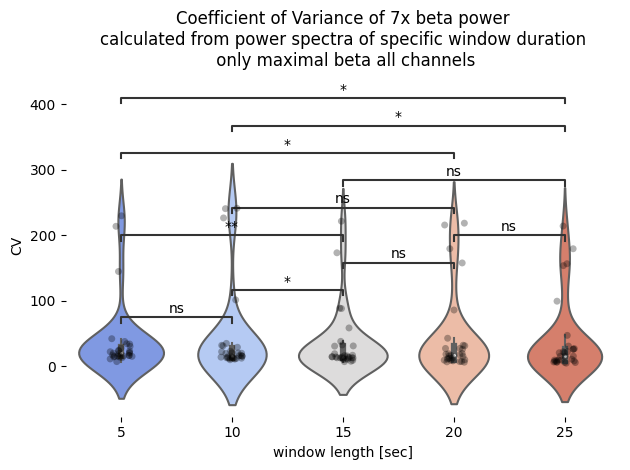

In [16]:
plot_multiple_CV = externalized_short_chunks.plot_CV_multiple_durations(filtered="notch_and_band_pass_filtered", 
                                                                        freq_band="beta", 
                                                                        channel_group="all",
                                                                        sec_per_epochs_list=[5,10,15,20,25],
                                                                        number_epochs=7

)

In [17]:
plot_multiple_CV

,data_info,sample_size,mean,std,median,outliers_indices,outliers_values,n_outliers,min,max,25%,50%,75%,shapiro_wilk_stat,shapiro_wilk_p,normal_distribution,outlier_patient_ids
0,5,30,38.612592,54.376147,20.090636,"Index([4, 10, 11], dtype='int64')","[144.7967411491266, 213.80370409700302, 229.83...",3,7.217606,229.830782,15.596307,20.090636,29.915158,0.487279,3.941989e-09,False,"[029_Right_1A2A, 052_Right_1B2B, 052_Left_01]"
1,10,30,42.626299,66.580343,16.385148,"Index([4, 10, 11, 21], dtype='int64')","[226.56606370153062, 240.73675187507888, 241.3...",4,10.074345,241.317799,12.987282,16.385148,27.616901,0.482998,3.559063e-09,False,"[029_Right_2B2C, 052_Right_1B2B, 052_Left_01, ..."
2,15,30,34.595159,48.504482,14.412874,"Index([2, 4, 10, 11, 21], dtype='int64')","[58.60365173910902, 88.21373419305259, 173.350...",5,7.119575,221.628596,12.770669,14.412874,31.076928,0.552078,1.992140e-08,False,"[025_Right_1A2A, 029_Right_1A2A, 052_Right_1B2..."
3,20,30,42.669051,61.529496,17.135842,"Index([4, 5, 10, 11, 21], dtype='int64')","[218.57761648389302, 179.6061076473103, 157.85...",5,6.312307,218.577616,10.309056,17.135842,30.394097,0.584203,4.707546e-08,False,"[029_Right_2B2C, 029_Left_1B1C, 052_Right_1B2B..."
4,25,30,39.792686,56.962747,15.421683,"Index([4, 5, 10, 11, 21], dtype='int64')","[153.74209363841857, 179.5243201151743, 156.63...",5,4.825858,214.194965,8.288087,15.421683,26.857331,0.612941,1.053869e-07,False,"[029_Right_1A2A, 029_Left_1B1C, 052_Right_1B2B..."


excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=1.6380838019358634e-08)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=2.7713780159643875e-09)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=5.271567005138422e-08)
ex

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/results/power_spectra_BSSU_externalized_notch_and_band_pass_filtered_2min_and_30sec_9epochs.pickle'

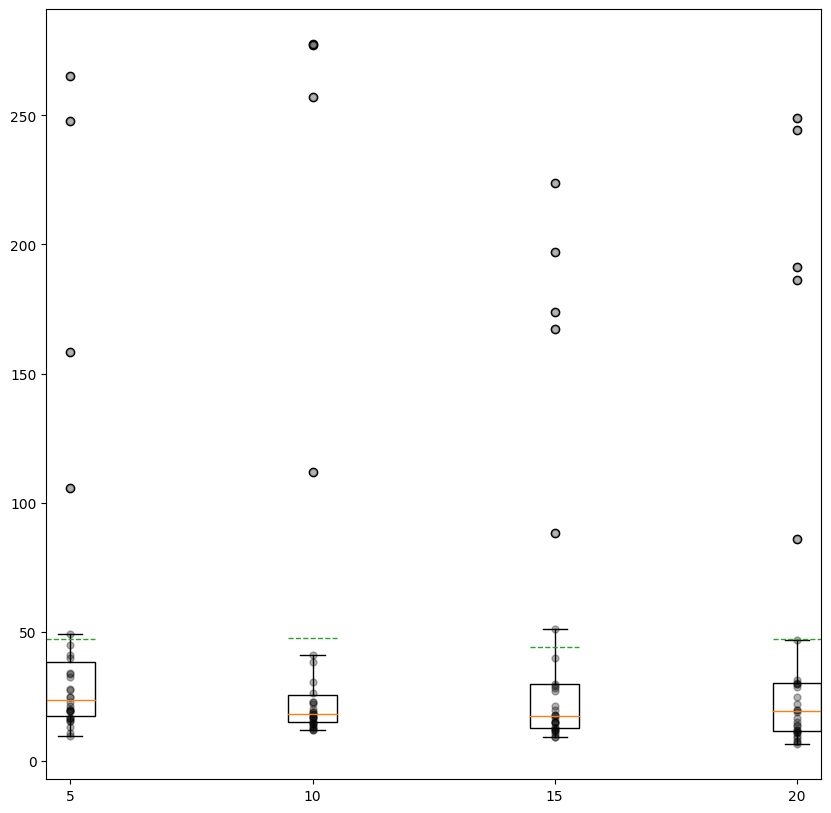

In [3]:
plot_multiple_CV = externalized_short_chunks.plot_coefficient_of_variation_multiple_durations(filtered="notch_and_band_pass_filtered", 
                                                                                              freq_band="beta", 
                                                                                              channel_group="all",
                                                                                              sec_per_epochs_list=[5,10,15,20],
                                                                                              number_epochs=9)

In [10]:
plot_multiple_CV

,data_info,sample_size,mean,std,median,outliers_indices,outliers_values,n_outliers,min,max,25%,50%,75%,shapiro_wilk_stat,shapiro_wilk_p,normal_distribution,outlier_patient_ids
0,5,30,38.612592,54.376147,20.090636,"Index([4, 10, 11], dtype='int64')","[144.7967411491266, 213.80370409700302, 229.83...",3,7.217606,229.830782,15.596307,20.090636,29.915158,0.487279,3.941989e-09,False,"[029_Right_1A2A, 052_Right_1B2B, 052_Left_01]"
1,10,30,42.626299,66.580343,16.385148,"Index([4, 10, 11, 21], dtype='int64')","[226.56606370153062, 240.73675187507888, 241.3...",4,10.074345,241.317799,12.987282,16.385148,27.616901,0.482998,3.559063e-09,False,"[029_Right_2B2C, 052_Right_1B2B, 052_Left_01, ..."
2,15,30,34.595159,48.504482,14.412874,"Index([2, 4, 10, 11, 21], dtype='int64')","[58.60365173910902, 88.21373419305259, 173.350...",5,7.119575,221.628596,12.770669,14.412874,31.076928,0.552078,1.992140e-08,False,"[025_Right_1A2A, 029_Right_1A2A, 052_Right_1B2..."
3,20,30,42.669051,61.529496,17.135842,"Index([4, 5, 10, 11, 21], dtype='int64')","[218.57761648389302, 179.6061076473103, 157.85...",5,6.312307,218.577616,10.309056,17.135842,30.394097,0.584203,4.707546e-08,False,"[029_Right_2B2C, 029_Left_1B1C, 052_Right_1B2B..."
4,25,30,39.792686,56.962747,15.421683,"Index([4, 5, 10, 11, 21], dtype='int64')","[153.74209363841857, 179.5243201151743, 156.63...",5,4.825858,214.194965,8.288087,15.421683,26.857331,0.612941,1.053869e-07,False,"[029_Right_1A2A, 029_Left_1B1C, 052_Right_1B2B..."


In [9]:
plot_multiple_CV.outlier_patient_ids.values[3]

array(['029_Right_2B2C', '029_Left_1B1C', '052_Right_1B2B',
       '069_Right_1B2B', '075_Right_1B1C', '077_Left_1B1C'], dtype=object)

Wilcoxon Signed Rank Test

In [69]:
wilcoxon = externalized_short_chunks.wilcoxon_signed_rank_test_between_CV(filtered="notch_and_band_pass_filtered",
                                                                        freq_band="beta",
                                                                        channel_group="all",
                                                                        sec_per_epochs_list=[5,10,15,20,25],
                                                                        number_epochs=7)

excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded:

In [70]:
wilcoxon

,epoch_length_1,epoch_length_2,statistic,p_value,significant
0,5,10,194.0,0.125520,False
1,5,15,113.0,0.002086,True
2,5,20,148.0,0.016916,True
3,5,25,201.0,0.160046,False
4,10,15,159.0,0.029284,True
5,10,20,182.0,0.079849,False
6,10,25,216.0,0.256533,False
7,15,20,216.0,0.256533,False
8,15,25,259.0,0.711099,False
9,20,25,215.0,0.249088,False


excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


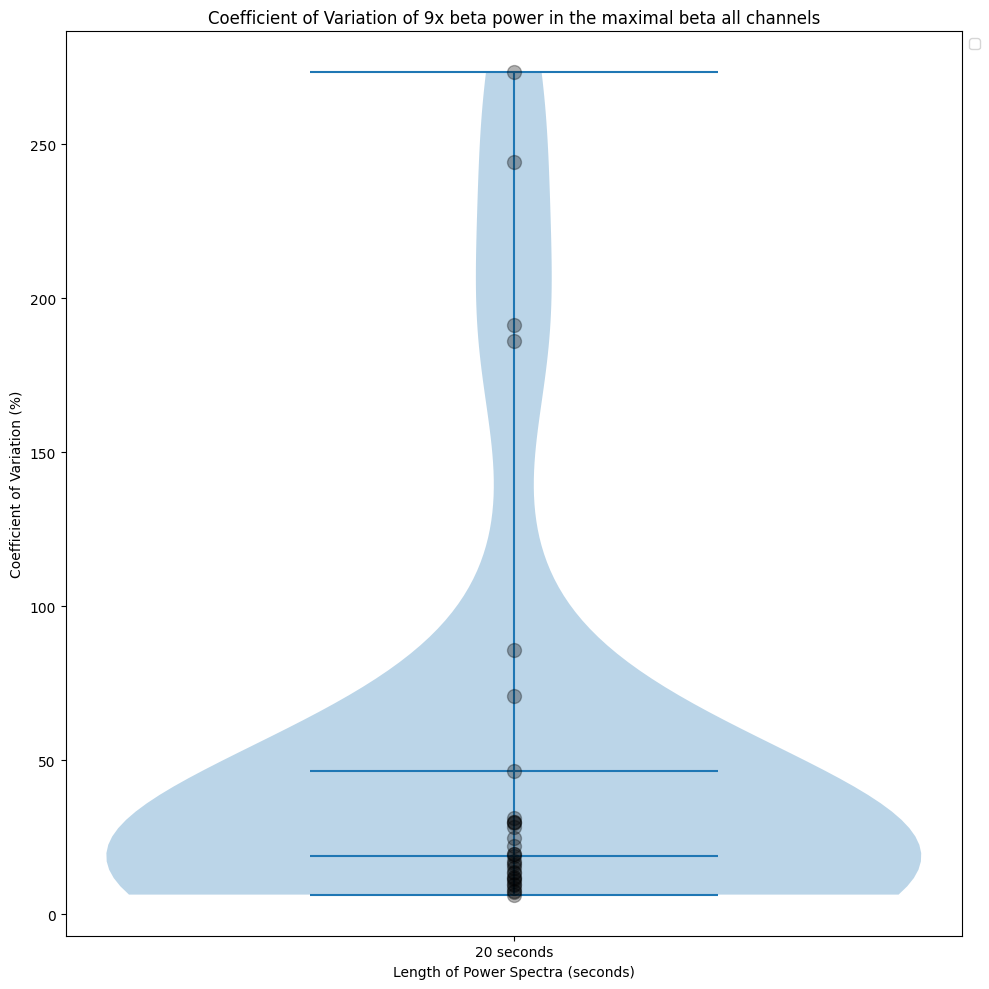

Figures Coefficient_of_Variation_9x_20sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered.svg and Coefficient_of_Variation_9x_20sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


In [6]:
Plot_CV = externalized_short_chunks.plot_coefficient_of_variation(filtered="notch_and_band_pass_filtered", 
                                                                  freq_band="beta", 
                                                                  channel_group="all", 
                                                                  sec_per_epoch=20,
                                                                  number_epochs=9)

Tukey Mean Difference Plot
- of maximal beta channels only (one channel per hemisphere)
- per hemisphere 5 x 20 sec beta power: calculate their MEAN and their DIFFERENCE TO MEAN within each hemisphere

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


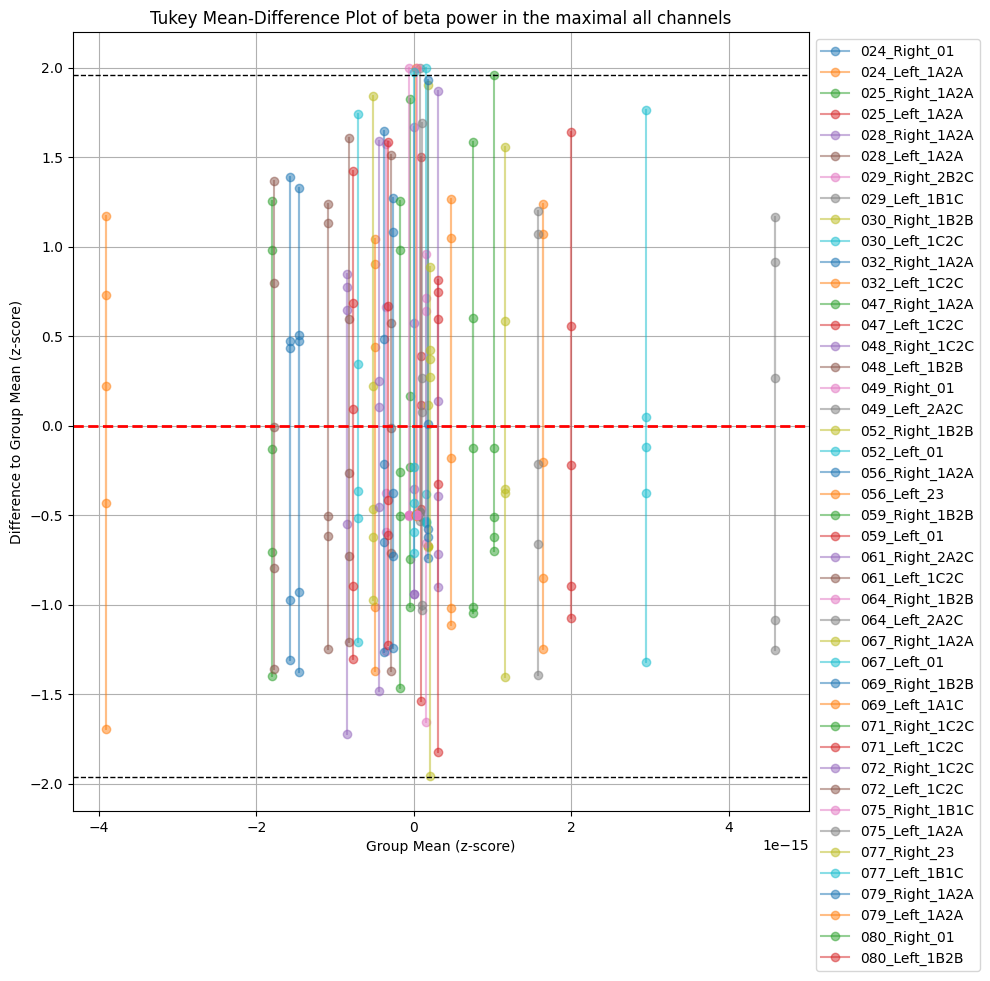

Figures Tukey_Mean_Difference_Plot_20sec_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_z_score_yes.svg and Tukey_Mean_Difference_Plot_20sec_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_z_score_yes.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


In [48]:
tukey_mean_difference_plot = externalized_short_chunks.tukey_mean_difference_plot(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all", z_score="yes")

In [44]:
print(f"mean of all differences:{tukey_mean_difference_plot[0]}", # mean of all differences,
f"\nconfidence interval upper border:{tukey_mean_difference_plot[1]}", # confidence interval upper border
f"\nconfidence interval lower border:{tukey_mean_difference_plot[2]}", # confidence interval lower border
f"\nsample size:{tukey_mean_difference_plot[3]}") 

mean of all differences:-1.0092936587501423e-18 
confidence interval upper border:1.96 
confidence interval lower border:-1.96 
sample size:44


### Spatial Distribution: Beta rank analysis of 5x20 sec externalized BSSU recordings

excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=2.0589251192859592e-08)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=4.927843377799945e-08)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=3.771851275757854e-09)
exc

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Figures Mean_rank_difference_to_rank1_of_2min_7x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_violinplot.svg and Mean_rank_difference_to_rank1_of_2min_7x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_violinplot.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


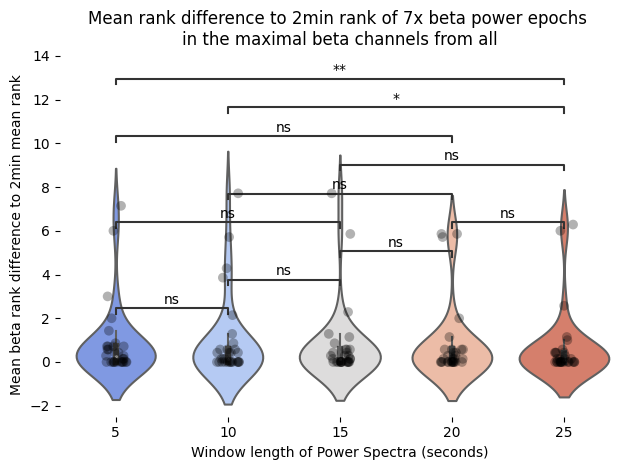

In [26]:
# Wilcovon signed rank test between the rank differences of the 2 min and the short epochs

wilcoxon = externalized_short_chunks.wilcoxon_signed_rank_test_between_diff_to_rank(
    filtered="notch_and_band_pass_filtered", 
    freq_band="beta", 
    channel_group="all", 
    rank_of_interest=1,
    sec_per_epochs_list=[5,10,15,20,25], 
    number_epochs=7,
    group_or_2min_mean="2min",
    outliers_excluded="no"
    )

In [29]:
wilcoxon[0]

,epoch_length_1,epoch_length_2,statistic,p_value,significant
0,5,10,84.5,0.965172,False
1,5,15,47.0,0.052321,False
2,5,20,45.5,0.080205,False
3,5,25,16.5,0.002561,True
4,10,15,20.5,0.079688,False
5,10,20,53.5,0.161885,False
6,10,25,29.5,0.025630,True
7,15,20,45.0,0.388935,False
8,15,25,19.0,0.115398,False
9,20,25,32.0,0.579991,False


excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=2.0589251192859592e-08)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=4.927843377799945e-08)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=3.771851275757854e-09)
exc

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


5 vs. 15: Wilcoxon test (paired samples), P_val:5.232e-02 Stat=4.700e+01
10 vs. 20: Wilcoxon test (paired samples), P_val:1.619e-01 Stat=5.350e+01
15 vs. 25: Wilcoxon test (paired samples), P_val:1.154e-01 Stat=1.900e+01
5 vs. 20: Wilcoxon test (paired samples), P_val:8.021e-02 Stat=4.550e+01
10 vs. 25: Wilcoxon test (paired samples), P_val:2.563e-02 Stat=2.950e+01
5 vs. 25: Wilcoxon test (paired samples), P_val:2.561e-03 Stat=1.650e+01
Figures Mean_rank_difference_to_rank1_of_2min_7x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_violinplot.svg and Mean_rank_difference_to_rank1_of_2min_7x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_violinplot.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


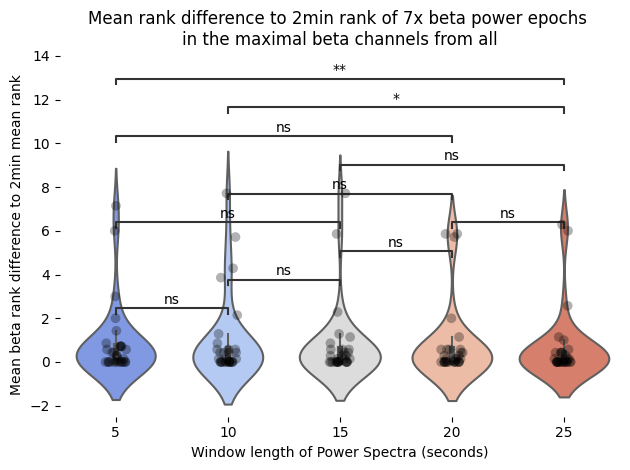

In [27]:
violin_plot_rank_differences = externalized_short_chunks.differences_to_mean_rank_plot(
    filtered="notch_and_band_pass_filtered", 
    freq_band="beta", 
    channel_group="all", 
    rank_of_interest=1,
    sec_per_epoch= [5, 10, 15, 20,25], 
    number_epochs=7,
    group_or_2min_mean="2min",
    plot_type="violinplot"
)

In [19]:
violin_plot_rank_differences["all_data"][5]

[0.0,
 0.0,
 0.0,
 0.0,
 1.4285714285714286,
 7.142857142857143,
 0.42857142857142855,
 0.7142857142857143,
 0.7142857142857143,
 0.5714285714285714,
 6.0,
 3.0,
 0.0,
 0.14285714285714285,
 0.7142857142857143,
 0.0,
 0.7142857142857143,
 0.42857142857142855,
 0.8571428571428571,
 0.14285714285714285,
 0.0,
 0.2857142857142857,
 0.5714285714285714,
 0.0,
 0.2857142857142857,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0]

In [28]:
violin_plot_rank_differences["sample_size_and_infos"]

,data_info,sample_size,mean,std,median,outliers_indices,outliers_values,n_outliers,min,max,25%,50%,75%,shapiro_wilk_stat,shapiro_wilk_p,normal_distribution,outlier_patient_ids,patient_ids
0,5,30,0.871429,1.666129,0.285714,"[5, 10, 11, 26]","[7.142857142857143, 6.0, 3.0, 2.0]",4,0.0,7.142857,0.0,0.285714,0.714286,0.553338,2.058925e-08,False,"[029_Left_1B1C, 052_Right_1B2B, 052_Left_01, 0...","[024_Right_01, 024_Left_1A2A, 025_Right_1A2A, ..."
1,10,30,0.990476,1.868439,0.142857,"[4, 5, 10, 11, 18]","[4.285714285714286, 7.714285714285714, 5.71428...",5,0.0,7.714286,0.0,0.142857,0.571429,0.585869,4.927843e-08,False,"[029_Right_2B2C, 029_Left_1B1C, 052_Right_1B2B...","[024_Right_01, 024_Left_1A2A, 025_Right_1A2A, ..."
2,15,30,0.766667,1.700533,0.142857,"[5, 10, 11]","[7.714285714285714, 5.857142857142857, 2.28571...",3,0.0,7.714286,0.0,0.142857,0.571429,0.485434,3.771851e-09,False,"[029_Left_1B1C, 052_Right_1B2B, 052_Left_01]","[024_Right_01, 024_Left_1A2A, 025_Right_1A2A, ..."
3,20,30,0.828571,1.711665,0.142857,"[4, 5, 10, 11]","[5.714285714285714, 5.857142857142857, 5.85714...",4,0.0,5.857143,0.0,0.142857,0.571429,0.507553,6.445684e-09,False,"[029_Right_2B2C, 029_Left_1B1C, 052_Right_1B2B...","[024_Right_01, 024_Left_1A2A, 025_Right_1A2A, ..."
4,25,30,0.671429,1.550576,0.071429,"[4, 5, 10, 11]","[1.1428571428571428, 6.285714285714286, 6.0, 2...",4,0.0,6.285714,0.0,0.071429,0.428571,0.471031,2.682583e-09,False,"[029_Right_1A2A, 029_Left_1B1C, 052_Right_1B2B...","[024_Right_01, 024_Left_1A2A, 025_Right_1A2A, ..."


Get beta ranks for each bipolar BSSU channel within each 20sec recording

In [76]:
# first get the ranked beta power of the 2 min externalized recordings
# channel group "all" = 12 BSSU channels, 12 ranks
ranked_power_2min = externalized_short_chunks.rank_power_2min(filtered="notch_and_band_pass_filtered", 
                                                              freq_band="beta", 
                                                              channel_group="all",
                                                              sec_per_epoch=20, 
                                                              number_epochs=9)

excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right


In [83]:
ranked_power_short_sec = externalized_short_chunks.rank_short_sec_power_channels(
    filtered="notch_and_band_pass_filtered", 
    freq_band="beta", 
    rank_of_interest=1,
    channel_group="all", 
    sec_per_epoch=20, 
    number_epochs=9)

excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right


In [87]:
ranked_power_short_sec["only_one_2min_rank_data"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_2min_mean,power_spectrum_2min_sd,power_spectrum_sec_1,power_spectrum_sec_1_mean,power_spectrum_sec_1_sd,...,rank_2min,rank_sec_1,rank_sec_2,rank_sec_3,rank_sec_4,rank_sec_5,rank_sec_6,rank_sec_7,rank_sec_8,rank_sec_9
0,024,Right,01,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[8.099790478708297e-13, 1.0207632241725114e-12...",5.880111e-13,4.007685e-13,"[1.6264619924721886e-13, 2.906972073504528e-14...",6.255412e-13,9.394235e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,024,Right,01,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[8.099790478708297e-13, 1.0207632241725114e-12...",5.880111e-13,4.007685e-13,"[1.6264619924721886e-13, 2.906972073504528e-14...",6.255412e-13,9.394235e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,024,Left,1A2A,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[9.11543722493552e-13, 1.0044045380048698e-12,...",5.414835e-13,4.130314e-13,"[7.960021390535592e-13, 7.244745816556028e-13,...",5.522362e-13,8.142218e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,024,Right,01,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[8.099790478708297e-13, 1.0207632241725114e-12...",5.880111e-13,4.007685e-13,"[1.6264619924721886e-13, 2.906972073504528e-14...",6.255412e-13,9.394235e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,024,Left,1A2A,"[13.0, 13.05, 13.100000000000001, 13.15, 13.20...","[9.11543722493552e-13, 1.0044045380048698e-12,...",5.414835e-13,4.130314e-13,"[7.960021390535592e-13, 7.244745816556028e-13,...",5.522362e-13,8.142218e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 052_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 079_Right


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Data is not normally distributed (p=3.2846012576470685e-09)


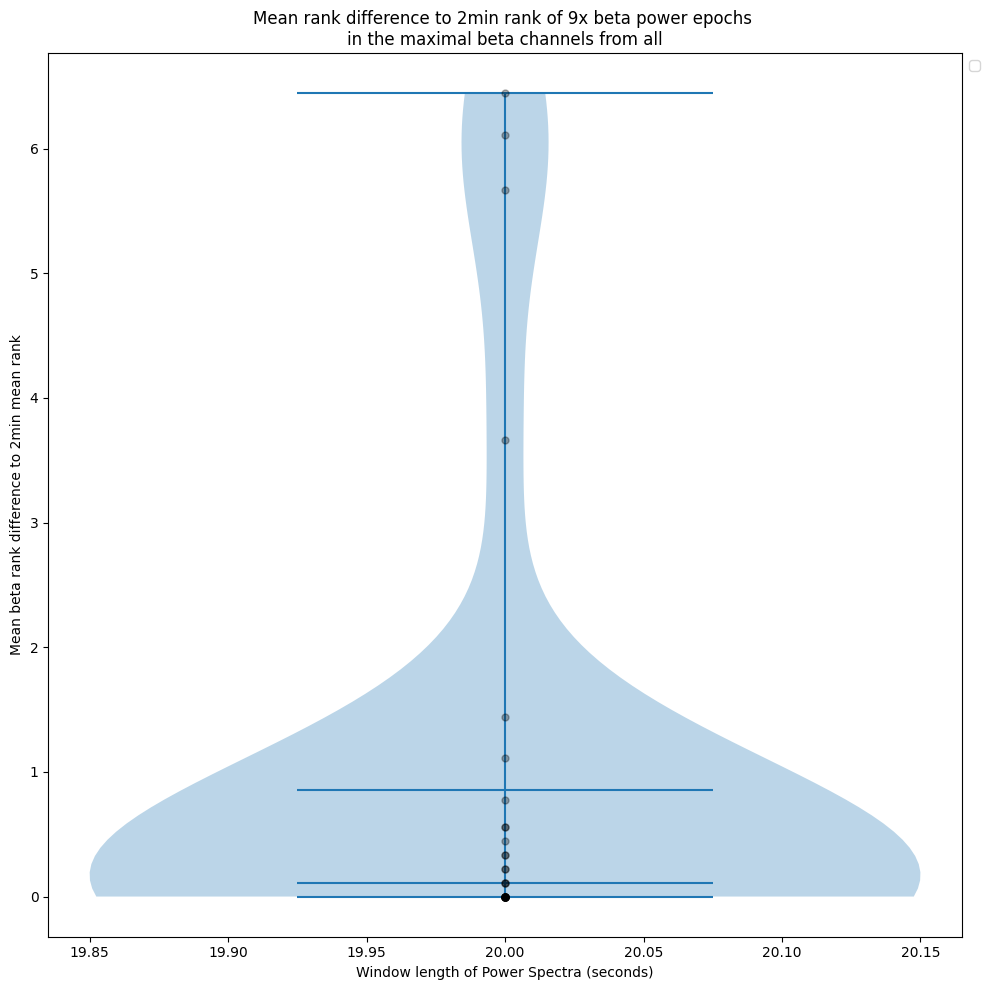

Figures Mean_rank_difference_to_rank1_of_2min_9x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_violinplot.svg and Mean_rank_difference_to_rank1_of_2min_9x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_violinplot.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


In [37]:
plot_differences_of_ranks = externalized_short_chunks.differences_to_mean_rank(
    filtered="notch_and_band_pass_filtered", 
    freq_band="beta", 
    channel_group="all", 
    rank_of_interest=1,
    sec_per_epoch= [20], #[20, 15, 10, 5], 
    number_epochs=9,
    group_or_2min_mean="2min",
    plot_type="violinplot")


In [32]:
plot_differences_of_ranks["all_data_df"].epochs.values

20

excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=1.3379054308870764e-08)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=2.6653328433212664e-08)
excluded: 028_Right
excluded: 028_Left
excluded: 030_Left
excluded: 032_Right
excluded: 032_Left
excluded: 048_Right
excluded: 048_Left
excluded: 049_Left
excluded: 061_Right
excluded: 069_Left
excluded: 071_Right
excluded: 072_Right
excluded: 075_Right
excluded: 077_Left
Data is not normally distributed (p=4.725137614514097e-09)
ex

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Figures Mean_rank_difference_to_rank1_of_2min_9x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_violinplot.svg and Mean_rank_difference_to_rank1_of_2min_9x_multiple_sec_spectra_externalized_BSSU_maximal_beta_all_notch_and_band_pass_filtered_violinplot.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


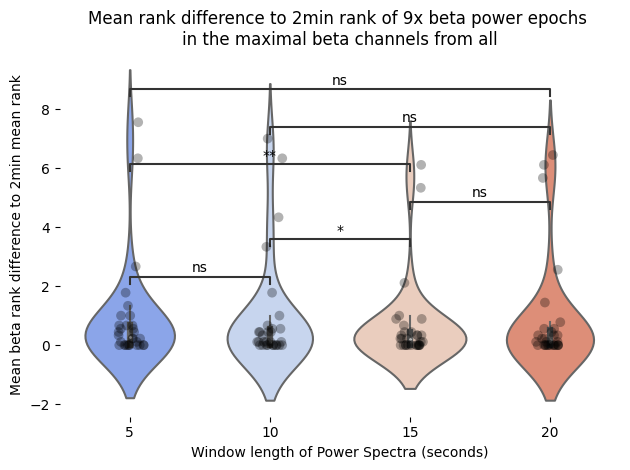

In [21]:
# Wilcovon signed rank test between the rank differences of the 2 min and the short epochs

wilcoxon = externalized_short_chunks.wilcoxon_signed_rank_test_between_diff_to_rank(
    filtered="notch_and_band_pass_filtered", 
    freq_band="beta", 
    channel_group="all", 
    rank_of_interest=1,
    sec_per_epochs_list=[5,10,15,20], 
    number_epochs=9,
    group_or_2min_mean="2min",
    outliers_excluded="no"
    )

In [22]:
wilcoxon[0]

,epoch_length_1,epoch_length_2,statistic,p_value,significant
0,5,10,63.0,0.326225,False
1,5,15,20.5,0.002650,True
2,5,20,56.5,0.120889,False
3,10,15,37.0,0.018553,True
4,10,20,66.5,0.250653,False
5,15,20,60.0,0.261907,False


In [23]:
wilcoxon[1]

{5: 30, 10: 30, 15: 30, 20: 30}

## Variance of rank differences of multiple short epochs within 2min (NON-FOOOF band-pass, notch filtered)

### Preparation

In [7]:
load_data = externalized_short_chunks.load_2min_and_all_short_epochs_power_spectra(incl_sub=["all"], 
                                                                                   filtered="notch_and_band_pass_filtered", 
                                                                                   sec_per_epoch=5)

In [16]:
load_data.head()

,bids_id,subject,hemisphere,channel,power_spectrum_2_min,frequencies,number_of_epochs,power_spectrum_5_sec_1,power_spectrum_5_sec_2,power_spectrum_5_sec_3,...,power_spectrum_5_sec_38,power_spectrum_5_sec_39,power_spectrum_5_sec_40,power_spectrum_5_sec_41,power_spectrum_5_sec_42,power_spectrum_5_sec_43,power_spectrum_5_sec_44,power_spectrum_5_sec_45,power_spectrum_5_sec_46,power_spectrum_5_sec_47
0,noBIDS24,024,Right,01,"[1.5100857888014485e-15, 7.524706665556482e-16...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[1.0425928482878666e-14, 5.181201912038796e-15...","[9.565938270971847e-19, 4.715473280802649e-19,...","[4.858102010483005e-15, 2.418351312385436e-15,...",...,"[3.528147222583647e-16, 1.7556639756078234e-16...","[3.1580658343187165e-16, 1.5864626008918576e-1...","[7.130261837193647e-16, 3.5511932950917983e-16...","[4.6598975245370226e-15, 2.324169538172118e-15...","[1.3066358324035647e-16, 6.520206116789617e-17...","[2.733012266249526e-15, 1.3624534289631873e-15...","[3.826753603088865e-16, 1.9079898987807841e-16...","[1.6407814209501768e-15, 8.188860993633906e-16...","[9.207737498709578e-16, 4.608088000799561e-16,...","[6.67216623536344e-15, 3.316922478942544e-15, ..."
1,noBIDS24,024,Right,12,"[1.876670424567965e-16, 9.348667290547057e-17,...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[3.332433877827032e-16, 1.6597331817992164e-16...","[4.622889263318262e-17, 2.2990538141322614e-17...","[2.0228230466046405e-16, 1.0066394941451733e-1...",...,"[4.2301624520000525e-17, 2.1120360073705525e-1...","[7.785285760078455e-17, 3.867093078203339e-17,...","[6.37448490119382e-18, 3.200413213408887e-18, ...","[1.6775894134747925e-16, 8.38986943411219e-17,...","[7.787749110728794e-17, 3.868367879332199e-17,...","[2.0680621205955795e-16, 1.0322800388159209e-1...","[3.161112675990376e-17, 1.5672499326148048e-17...","[1.0578263886678015e-17, 5.298885316112574e-18...","[1.8460532095150096e-16, 9.197082324938822e-17...","[7.557654334620123e-16, 3.73564906019715e-16, ..."
2,noBIDS24,024,Right,23,"[6.378561745336953e-17, 3.1745517536579823e-17...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[3.615068356466237e-18, 1.8128957318930584e-18...","[5.520697142407693e-19, 2.8633575932891783e-19...","[1.4570580468080438e-17, 7.297395034944514e-18...",...,"[8.281136467762102e-21, 6.228125820617199e-21,...","[3.1809602083023974e-17, 1.5768553823227604e-1...","[1.0696138319484307e-17, 5.340324140334024e-18...","[5.5003933256370234e-17, 2.7342413196100423e-1...","[6.2546945658434825e-18, 3.074406694485785e-18...","[2.8182701181269696e-17, 1.4027866022342094e-1...","[4.8035461404969726e-17, 2.4047629763617653e-1...","[1.7492015745097374e-16, 8.716618007724057e-17...","[1.4353509387463867e-16, 7.16494965996953e-17,...","[8.0041419106355515e-16, 3.9640613315841676e-1..."
3,noBIDS24,024,Right,1A2A,"[5.242145935430479e-16, 2.6113521675480335e-16...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[3.0045028551871234e-15, 1.4956790417688648e-1...","[2.8055978641351095e-16, 1.3943108183829887e-1...","[9.68401782356017e-17, 4.8252361178526356e-17,...",...,"[3.494850985958339e-17, 1.738502629330426e-17,...","[1.6531993857494213e-16, 8.212072001417229e-17...","[5.301116961686862e-17, 2.6492790085871198e-17...","[1.9272620871646239e-16, 9.665442301840303e-17...","[2.214161638198432e-16, 1.1029565697760137e-16...","[2.559320565620233e-16, 1.2773371759802073e-16...","[3.683913388509518e-16, 1.8341767833265876e-16...","[2.2283609284826996e-16, 1.110993457143811e-16...","[6.189797363951795e-16, 3.0809891149028966e-16...","[1.4198183123619874e-15, 7.0141230944585595e-1..."
4,noBIDS24,024,Right,1B2B,"[1.1149779141078224e-16, 5.556506271397849e-17...","[0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, ...",47,"[1.7695280032300574e-16, 8.784113133537415e-17...","[7.359207449107944e-17, 3.673784934839923e-17,...","[3.309419812575253e-16, 1.6483688881628115e-16...",...,"[1.1952068923512303e-17, 6.037048347895099e-18...","[8.106042

In [3]:
freq_result = externalized_short_chunks.frequency_band_mean_sd_all_epochs(incl_sub=["all"], 
                                     filtered="notch_and_band_pass_filtered", 
                                     sec_per_epoch=5)

Power spectrum power_spectrum_5_sec_46 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Righ

In [31]:
freq_result["beta_band_result"].number_of_epochs.values[0]

47

In [3]:
rank_all_epochs = externalized_short_chunks.rank_power_2min_all_epochs(
    incl_sub=["all"], 
    filtered="notch_and_band_pass_filtered", 
    sec_per_epoch=5,
    freq_band="beta",
    channel_group="all")
    

Power spectrum power_spectrum_5_sec_46 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Righ

In [11]:
# check if there are NaNs in number of epochs:
rank_all_epochs["ranked_power_2min"].subject.values

array(['024', '024', '024', '024', '024', '024', '024', '024', '024',
       '024', '024', '024', '024', '024', '024', '024', '024', '024',
       '024', '024', '024', '024', '024', '024', '025', '025', '025',
       '025', '025', '025', '025', '025', '025', '025', '025', '025',
       '025', '025', '025', '025', '025', '025', '025', '025', '025',
       '025', '025', '025', '029', '029', '029', '029', '029', '029',
       '029', '029', '029', '029', '029', '029', '029', '029', '029',
       '029', '029', '029', '029', '029', '029', '029', '029', '029',
       '030', '030', '030', '030', '030', '030', '030', '030', '030',
       '030', '030', '030', '047', '047', '047', '047', '047', '047',
       '047', '047', '047', '047', '047', '047', '047', '047', '047',
       '047', '047', '047', '047', '047', '047', '047', '047', '047',
       '049', '049', '049', '049', '049', '049', '049', '049', '049',
       '049', '049', '049', '052', '052', '052', '052', '052', '052',
       '052', '052',

In [8]:
get_ranks_of_short_epochs = externalized_short_chunks.get_ranks_short_sec_power_channels(
    incl_sub=["all"], 
    filtered="notch_and_band_pass_filtered", 
    sec_per_epoch=5,
    freq_band="beta",
    channel_group="all",
    rank_of_interest=1)

Power spectrum power_spectrum_5_sec_46 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Righ

In [9]:
get_ranks_of_short_epochs["only_one_2min_rank_data"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_2min_mean,power_spectrum_2min_sd,number_of_epochs,power_spectrum_sec_1,power_spectrum_sec_1_mean,...,rank_sec_38,rank_sec_39,rank_sec_40,rank_sec_41,rank_sec_42,rank_sec_43,rank_sec_44,rank_sec_45,rank_sec_46,rank_sec_47
0,024,Right,01,"[13.0, 13.200000000000001, 13.4, 13.6000000000...","[9.168807302489778e-13, 9.108404898139657e-13,...",5.689273e-13,3.437259e-13,47,"[6.476298210226003e-13, 5.990603101671504e-13,...",4.322870e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,024,Right,01,"[13.0, 13.200000000000001, 13.4, 13.6000000000...","[9.168807302489778e-13, 9.108404898139657e-13,...",5.689273e-13,3.437259e-13,47,"[6.476298210226003e-13, 5.990603101671504e-13,...",4.322870e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,024,Left,1A2A,"[13.0, 13.200000000000001, 13.4, 13.6000000000...","[1.0773511161631502e-12, 1.1557849719089286e-1...",5.393319e-13,3.764659e-13,47,"[2.886633392778892e-14, 2.2110518061659816e-13...",6.467472e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,024,Right,01,"[13.0, 13.200000000000001, 13.4, 13.6000000000...","[9.168807302489778e-13, 9.108404898139657e-13,...",5.689273e-13,3.437259e-13,47,"[6.476298210226003e-13, 5.990603101671504e-13,...",4.322870e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,024,Left,1A2A,"[13.0, 13.200000000000001, 13.4, 13.6000000000...","[1.0773511161631502e-12, 1.1557849719089286e-1...",5.393319e-13,3.764659e-13,47,"[2.886633392778892e-14, 2.2110518061659816e-13...",6.467472e-13,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [6]:
rank_variance_of_maximal_beta_channel = externalized_short_chunks.rank_variance_of_maximal_beta_channel(
    incl_sub=["all"], 
    filtered="notch_and_band_pass_filtered", 
    sec_per_epoch=30,
    freq_band="beta",
    channel_group="all",
    rank_of_interest=1)

Power spectrum power_spectrum_30_sec_7 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1A1C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1B1C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 2A2B is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 2A2C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 2B2C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Left 01 is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 L

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [7]:
rank_variance_of_maximal_beta_channel

,data_info,sample_size,mean,std,median,outliers_indices,outliers_values,n_outliers,min,max,25%,50%,75%,iqr,cv,shapiro_wilk_stat,shapiro_wilk_p,normal_distribution
0,024_Right_01,7,1.000000,0.000000,1.0,[],[],0,1.0,1.0,1.00,1.0,1.00,0.00,0.000000,1.000000,1.000000,True
1,024_Left_1A2A,7,1.000000,0.000000,1.0,[],[],0,1.0,1.0,1.00,1.0,1.00,0.00,0.000000,1.000000,1.000000,True
2,025_Right_1A2A,6,1.000000,0.000000,1.0,[],[],0,1.0,1.0,1.00,1.0,1.00,0.00,0.000000,1.000000,1.000000,True
3,025_Left_1A2A,6,1.000000,0.000000,1.0,[],[],0,1.0,1.0,1.00,1.0,1.00,0.00,0.000000,1.000000,1.000000,True
4,029_Right_1A2A,6,2.166667,1.067187,2.0,[],[],0,1.0,4.0,1.25,2.0,2.75,1.50,49.254802,0.907578,0.420658,True
5,029_Left_1B1C,6,7.333333,2.924988,8.0,"[0, 3]","[10.0, 1.0]",2,1.0,10.0,8.00,8.0,8.75,0.75,39.886202,0.717156,0.009326,False
6,030_Right_1B2B,6,1.666667,0.471405,2.0,[],[],0,1.0,2.0,1.25,2.0,2.00,0.75,28.284271,0.639894,0.001351,False
7,047_Right_1A2A,7,1.000000,0.000000,1.0,[],[],0,1.0,1.0,1.00,1.0,1.00,0.00,0.000000,1.000000,1.000000,True
8,047_Left_1C2C,7,1.285714,0.451754,1.0,[],[],0,1.0,2.0,1.00,1.0,1.50,0.50,35.136418,0.600399,0.000275,False
9,049_Right_01,7,1.142857,0.349927,1.0,[2],[2.0],1,1.0,2.0,1.00,1.0,1.00,0.00,30.618622,0.452971,0.000004,False


### Analysis

Power spectrum power_spectrum_5_sec_46 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_5_sec_46 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_5_sec_47 of 025 Righ

/Users/jenniferbehnke/code/Monopolar_power_estimation/monopolar_directional_beta/src/monopolar_bssu/short_time_stability_power/externalized_short_chunks.py:558: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  maximal_power_data["patient_id"] = (
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Power spectrum power_spectrum_10_sec_23 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 1A1C is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 1B1C is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 2A2B is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 2A2C is a float!: nan
Power spectrum power_spectrum_10_sec_23 of 025 Right 2B2C is a float!: nan
Power spectrum power_spectrum_10_sec_22 of 025 Left 01 is a float!: nan
Power spectrum power_spectrum_10_s

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Power spectrum power_spectrum_20_sec_11 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1A1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 1B1C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2B is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2A2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Right 2B2C is a float!: nan
Power spectrum power_spectrum_20_sec_11 of 025 Left 01 is a float!: nan
Power spectrum power_spectrum_20_s

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Power spectrum power_spectrum_30_sec_7 of 025 Right 01 is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 12 is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 23 is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1A2A is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1B2B is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1C2C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1A1B is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1A1C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 1B1C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 2A2B is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 2A2C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Right 2B2C is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 Left 01 is a float!: nan
Power spectrum power_spectrum_30_sec_7 of 025 L

/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/jenniferbehnke/anaconda3/envs/bssu/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Figures cv_of_beta_ranks_multiple_sec_spectra_externalized_BSSU_2minrank_1_ring_notch_and_band_pass_filtered.svg and cv_of_beta_ranks_multiple_sec_spectra_externalized_BSSU_2minrank_1_ring_notch_and_band_pass_filtered.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


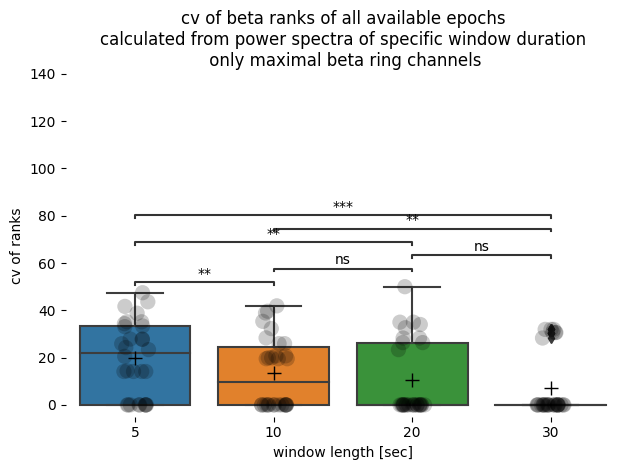

In [6]:
plot_comparison = externalized_short_chunks.compare_rank_variability_of_different_epoch_lengths(
    incl_sub=["all"], 
    filtered="notch_and_band_pass_filtered", 
    sec_per_epoch_list=[5, 10, 20, 30],
    freq_band="beta",
    channel_group="ring",
    rank_of_interest=1,
    variable_of_interest="cv" # "mean", "max", "iqr", "cv"
)

In [8]:
plot_comparison[0]

,data_info,sample_size,mean,std,median,outliers_indices,outliers_values,n_outliers,min,max,25%,50%,75%,shapiro_wilk_stat,shapiro_wilk_p,normal_distribution,outlier_patient_ids,mean_number_epochs,std_number_epochs,patient_ids
0,5,30,38.230689,20.922705,38.593049,"Index([], dtype='int64')",[],0,0.0,68.922131,30.552461,38.593049,53.525535,0.905813,0.011687,False,[],45.433333,2.144493,"[024_Right_1A1B, 024_Left_1A2A, 025_Right_1A2A..."
1,10,30,32.610438,21.122746,34.841945,"Index([18], dtype='int64')",[81.3300887330964],1,0.0,81.330089,21.726659,34.841945,43.585110,0.925861,0.038164,False,[064_Left_2A2C],22.166667,1.147211,"[024_Right_1A1B, 024_Left_1A2A, 025_Right_1A2A..."
2,20,30,25.914721,20.101160,33.782997,"Index([], dtype='int64')",[],0,0.0,67.763093,0.000000,33.782997,38.960138,0.864712,0.001280,False,[],10.400000,0.770132,"[024_Right_1A1B, 024_Left_1A2A, 025_Right_1A2A..."
3,30,30,22.227267,20.527973,30.618622,"Index([], dtype='int64')",[],0,0.0,56.568542,0.000000,30.618622,37.651618,0.813883,0.000119,False,[],6.566667,0.504007,"[024_Right_1A1B, 024_Left_1A2A, 025_Right_1A2A..."


In [9]:
plot_comparison[0].patient_ids.values[0]

array(['024_Right_1A1B', '024_Left_1A2A', '025_Right_1A2A',
       '025_Left_1A2A', '029_Right_1A2A', '029_Left_1B1C',
       '030_Right_1B2B', '047_Right_1A2A', '047_Left_1C2C',
       '049_Right_1B2B', '052_Right_1B2B', '052_Left_2A2C',
       '056_Right_1A2A', '056_Left_1A2A', '059_Right_1B2B',
       '059_Left_1A1C', '061_Left_1C2C', '064_Right_1B2B',
       '064_Left_2A2C', '067_Right_1A2A', '067_Left_1B2B',
       '069_Right_1B2B', '071_Left_1C2C', '072_Left_1C2C',
       '075_Left_1A2A', '077_Right_1A2A', '079_Right_1A2A',
       '079_Left_1A2A', '080_Right_1A2A', '080_Left_1B2B'], dtype=object)

In [6]:
plot_comparison[1]

,epoch_length_1,epoch_length_2,statistic,p_value,significant
0,1,2,38.0,0.007062,True
1,1,3,29.0,0.002638,True
2,1,4,12.0,0.000321,True
3,2,3,34.0,0.139596,False
4,2,4,11.0,0.005348,True
5,3,4,14.0,0.167976,False


### Tukey Mean difference plot (OLD)

In [61]:
ranked_power_20sec = externalized_short_chunks.rank_20sec_power_channels(filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all", rank_of_interest=1)

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


In [64]:
ranked_power_20sec["all_ranked_power_20sec"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5,...,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,power_spectrum_20sec_5_sd,rank_2min,rank_20sec_1,rank_20sec_2,rank_20sec_3,rank_20sec_4,rank_20sec_5
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0,1.0,1.0,1.0,1.0,1.0
1,024,Right,12,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[9.441147341234419e-14, 7.274418241094575e-14,...","[9.121987733213792e-14, 8.119072538923668e-14,...","[1.267965799606627e-13, 8.919558150812431e-14,...","[7.063571409934557e-14, 5.611350518905433e-14,...","[8.909305949369696e-14, 5.817558001771653e-14,...","[9.618901671729255e-14, 6.49955013827536e-14, ...",...,3.032828e-14,1.755182e-14,2.147577e-14,2.214879e-14,7.0,7.0,6.0,7.0,6.0,6.0
2,024,Right,23,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[4.667347362373837e-14, 3.287950499246578e-14,...","[4.7037840969607093e-14, 3.046466872792286e-14...","[5.154677186968955e-14, 3.881348398263996e-14,...","[4.0721243441134103e-14, 2.846600956250689e-14...","[4.678075462719349e-14, 2.810839918951721e-14,...","[4.6372324909699805e-14, 3.583766887928919e-14...",...,1.019271e-14,8.629103e-15,9.493081e-15,8.584704e-15,12.0,12.0,12.0,12.0,12.0,12.0
3,024,Right,1A2A,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[2.908287511318268e-13, 2.2510070288293016e-13...","[3.066903279000984e-13, 2.3029900434534774e-13...","[4.2187079353657564e-13, 3.081934446205491e-13...","[2.0828924689717924e-13, 2.0223561911074607e-1...","[2.556445783965545e-13, 2.1375444938480986e-13...","[3.2847171119665546e-13, 2.1099923951354179e-1...",...,1.013090e-13,5.883262e-14,8.022382e-14,8.412637e-14,3.0,3.0,3.0,3.0,3.0,3.0
4,024,Right,1B2B,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[6.301136211421982e-14, 5.40385420645566e-14, ...","[5.633956542086752e-14, 6.061204692636232e-14,...","[5.824737798721049e-14, 5.052081684818284e-14,...","[4.8880123128621485e-14, 4.723724418552108e-14...","[6.372063753659436e-14, 5.017261017071023e-14,...","[6.524648436745796e-14, 4.502837294216937e-14,...",...,1.294839e-14,1.255904e-14,1.493481e-14,1.240240e-14,10.0,10.0,10.0,10.0,9.0,10.0


In [70]:
ranked_power_20sec["only_one_2min_rank_data"].head()

,subject,hemisphere,channel,frequencies,power_spectrum_2min,power_spectrum_20sec_1,power_spectrum_20sec_2,power_spectrum_20sec_3,power_spectrum_20sec_4,power_spectrum_20sec_5,...,power_spectrum_20sec_2_sd,power_spectrum_20sec_3_sd,power_spectrum_20sec_4_sd,power_spectrum_20sec_5_sd,rank_2min,rank_20sec_1,rank_20sec_2,rank_20sec_3,rank_20sec_4,rank_20sec_5
0,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0,1.0,1.0,1.0,1.0,1.0
1,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0,1.0,1.0,1.0,1.0,1.0
2,024,Left,1A2A,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.0516907520203434e-12, 7.983638205046127e-13...","[1.2263824681940984e-12, 7.734967445320256e-13...","[1.269884833999199e-12, 1.0120489070157936e-12...","[8.67981539273137e-13, 5.265113974646002e-13, ...","[7.125609469947546e-13, 5.562734909884045e-13,...","[1.3972921834874141e-12, 1.1273972882628835e-1...",...,4.032693e-13,2.923844e-13,3.053879e-13,4.014941e-13,1.0,1.0,1.0,1.0,1.0,1.0
3,024,Right,01,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.006959873681143e-12, 7.627618606373016e-13,...","[9.227261489012247e-13, 6.856116072561524e-13,...","[1.6238086629250652e-12, 1.0183756423828129e-1...","[7.63183402082647e-13, 6.122674865474809e-13, ...","[7.333007422693277e-13, 6.482917709124258e-13,...","[1.0377924563977723e-12, 8.049693773248429e-13...",...,4.310370e-13,2.884047e-13,4.183058e-13,3.434652e-13,1.0,1.0,1.0,1.0,1.0,1.0
4,024,Left,1A2A,"[13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....","[1.0516907520203434e-12, 7.983638205046127e-13...","[1.2263824681940984e-12, 7.734967445320256e-13...","[1.269884833999199e-12, 1.0120489070157936e-12...","[8.67981539273137e-13, 5.265113974646002e-13, ...","[7.125609469947546e-13, 5.562734909884045e-13,...","[1.3972921834874141e-12, 1.1273972882628835e-1...",...,4.032693e-13,2.923844e-13,3.053879e-13,4.014941e-13,1.0,1.0,1.0,1.0,1.0,1.0


Tukey mean difference plot of difference of ranks of selected channels 
- select a rank of interest: channel with power rank of 2min recording

20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist
20 sec rec number 6 does not exist


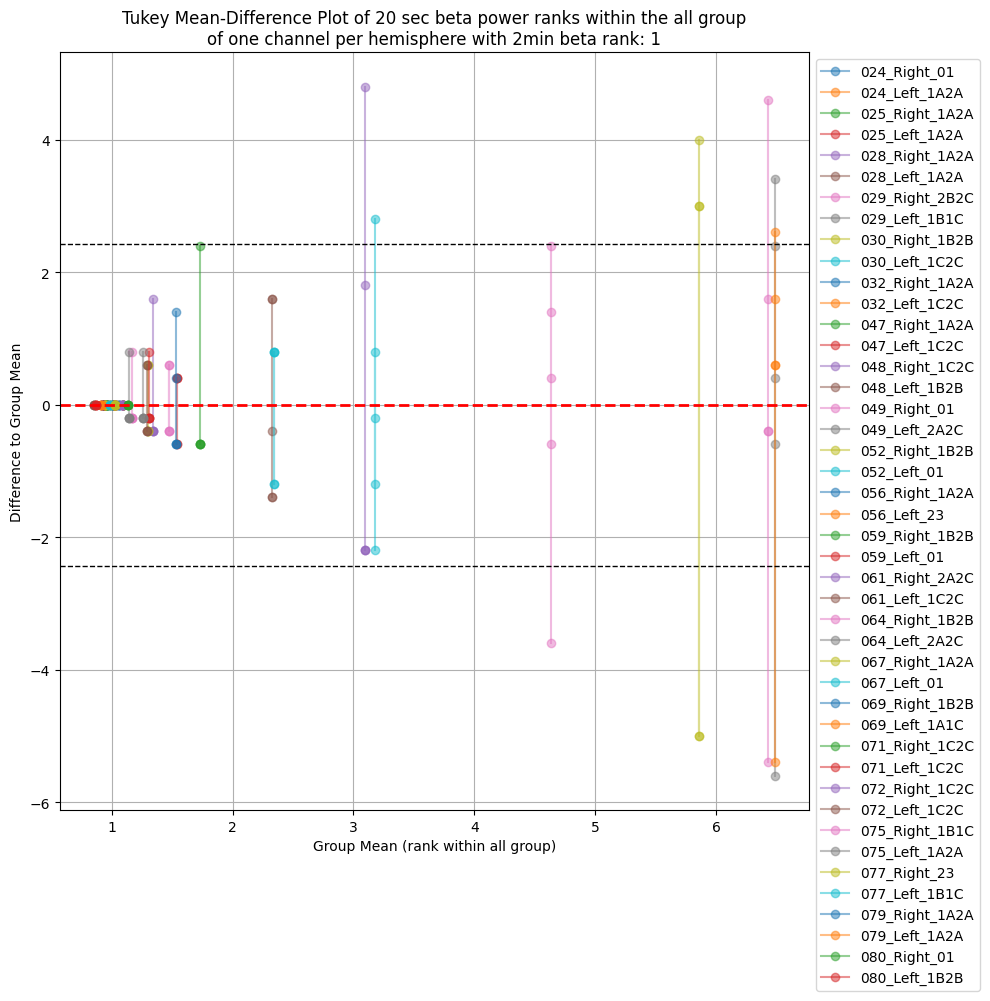

Figures Tukey_Mean_Difference_Plot_20sec_externalized_BSSU_ranks_beta_all_notch_and_band_pass_filtered_z_score_no_of_2min_channel_rank_1.svg and Tukey_Mean_Difference_Plot_20sec_externalized_BSSU_ranks_beta_all_notch_and_band_pass_filtered_z_score_no_of_2min_channel_rank_1.png 
were written in: /Users/jenniferbehnke/Dropbox/work/ResearchProjects/Monopolar_power_estimation/figures.


In [117]:
tukey_mean_difference_ranks = externalized_short_chunks.tukey_mean_difference_plot_20sec_ranks(
    filtered="notch_and_band_pass_filtered", freq_band="beta", channel_group="all", rank_of_interest=1, z_score="no")


In [116]:
print(f"mean of all differences:{tukey_mean_difference_ranks[0]}", # mean of all differences,
f"\nconfidence interval upper border:{tukey_mean_difference_ranks[1]}", # confidence interval upper border
f"\nconfidence interval lower border:{tukey_mean_difference_ranks[2]}", # confidence interval lower border
f"\nsample size:{tukey_mean_difference_ranks[3]}") 

mean of all differences:1.0092936587501423e-18 
confidence interval upper border:1.2536202121709894 
confidence interval lower border:-1.2536202121709894 
sample size:44
